In [1]:
import xgboost as xgb
import numpy as np
#import warnings
#warnings.filterwarnings('ignore')

C:\Users\12246\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\12246\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)  # Increase width to prevent line wrapping


file_path = "C:/Users/12246/Downloads/thesisPython/PBPdata/2023PBP.csv"
data = pd.read_csv(file_path)
#data.head()

In [3]:
teams = [
    'Air Force', 'Akron', 'Alabama', 'App State', 'Arizona', 'Arizona State', 'Arkansas', 'Arkansas State', 
    'Army', 'Auburn', 'Ball State', 'Baylor', 'Boise State', 'Boston College', 'Bowling Green', 'Buffalo', 
    'BYU', 'California', 'Central Michigan', 'Charlotte', 'Cincinnati', 'Clemson', 'Coastal Carolina', 
    'Colorado', 'Colorado State', 'Duke', 'East Carolina', 'Eastern Michigan', 'Florida', 'Florida Atlantic', 
    'Florida International', 'Florida State', 'Fresno State', 'Georgia', 'Georgia Southern', 'Georgia State', 
    'Georgia Tech', "Hawai'i", 'Houston', 'Illinois', 'Indiana', 'Iowa', 'Iowa State', 'Jacksonville State', 
    'James Madison', 'Kansas', 'Kansas State', 'Kent State', 'Kentucky', 'Liberty', 'Louisiana', 'Louisiana Tech', 
    'Louisville', 'LSU', 'Marshall', 'Maryland', 'Massachusetts', 'Memphis', 'Miami', 'Miami (OH)', 'Michigan', 
    'Michigan State', 'Middle Tennessee', 'Minnesota', 'Mississippi State', 'Missouri', 'Navy', 'NC State', 
    'Nebraska', 'Nevada', 'New Mexico', 'New Mexico State', 'North Carolina', 'Northern Illinois', 'North Texas', 
    'Northwestern', 'Notre Dame', 'Ohio', 'Ohio State', 'Oklahoma', 'Oklahoma State', 'Old Dominion', 'Ole Miss', 
    'Oregon', 'Oregon State', 'Penn State', 'Pittsburgh', 'Purdue', 'Rice', 'Rutgers', 'Sam Houston', 
    'San Diego State', 'San José State', 'SMU', 'South Alabama', 'South Carolina', 'Southern Miss', 'South Florida', 
    'Stanford', 'Syracuse', 'TCU', 'Temple', 'Tennessee', 'Texas', 'Texas A&M', 'Texas State', 'Texas Tech', 
    'Toledo', 'Troy', 'Tulane', 'Tulsa', 'UAB', 'UCF', 'UCLA', 'UConn', 'UL Monroe', 'UNLV', 'USC', 'Utah', 
    'Utah State', 'UTEP', 'UTSA', 'Vanderbilt', 'Virginia', 'Virginia Tech', 'Wake Forest', 'Washington', 
    'Washington State', 'Western Kentucky', 'Western Michigan', 'West Virginia', 'Wisconsin', 'Wyoming'
]

In [92]:
import pandas as pd
import numpy as np

def process_dataset(data, teams):
    data['has_possession'] = (data['start_team'] == data['home_abbr']).astype(int)
    data['new_drive'] = 0
    data['adjScore'] = data['score_diff'] / np.sqrt(data['sec_remaining'] + 1)

    data['drive_id']      = np.nan
    data['off_eff']       = np.nan
    data['rz_eff']        = np.nan
    data['to_rate']       = np.nan
    data['ex_play']       = np.nan
    data['def_eff']       = np.nan
    data['def_rz_eff']    = np.nan
    data['havoc_rate']    = np.nan
    data['points_scored'] = data['score_points']
    data['points_scored_drive'] = 0
    data['goal_to_go'] = 0

    for team_name in teams:
        team_games = data[(data['home_market'] == team_name) | (data['away_market'] == team_name)].copy()
        team_games = team_games.sort_values(by=['week', 'quarter', 'sec_remaining'], ascending=[True, True, False])

        if team_games.empty:
            print(f"{team_name} is empty!")
            continue  

        team_games = team_games.reset_index(drop=False)

        team_games['halftime'] = (team_games['quarter'] == 2) & (team_games['quarter'].shift(-1) == 3)
        team_games['next_start_team'] = team_games['start_team'].shift(-1)
        team_games['possession_change'] = (team_games['start_team'] != team_games['end_team']) | (team_games['start_team'] != team_games['next_start_team'])
        
        team_games['new_drive'] = 0
        team_games.loc[team_games['play_type'].shift(-1) == 'kickoff', 'new_drive'] = 1
        team_games.loc[0, ['drive_id', 'new_drive']] = [1, 0]
        team_games.loc[team_games['possession_change'], 'new_drive'] = 1

        team_games['next_match_id'] = team_games['match'].shift(-1)
        team_games['last_play_of_game'] = team_games['match'] != team_games['next_match_id']

        team_games.loc[(team_games['possession_change']) & (team_games['play_type'].shift(1) == 'kickoff'), 'new_drive'] = 0
        team_games.loc[((team_games['play_type'] == 'conversion') | (team_games['play_type'] == 'extra_point') | (team_games['play_type'] == 'field_goal')), 'new_drive'] = 1
        team_games.loc[team_games['last_play_of_game'], 'new_drive'] = 1
        team_games.loc[team_games['halftime'], 'new_drive'] = 1

        team_games['drive_id'] = team_games['new_drive'].shift(1).fillna(0).cumsum() + 1

        team_games.loc[(team_games['start_team'] != team_games['end_team']) & (team_games['score_points'] > 0), 'points_scored'] *= -1
        team_games['points_scored_drive'] = team_games.groupby(['match', 'drive_id'])['score_points'].transform('sum')
        team_games['scoring_drive'] = (team_games['points_scored_drive'] > 0).astype(int)

        team_games['rz_drive'] = 0
        team_games.loc[team_games['yds_to_goal'] <= 20, 'rz_drive'] = 1
        team_games['rz_drive'] = team_games.groupby(['match', 'drive_id'])['rz_drive'].transform('max')
        team_games.loc[team_games['yds_to_goal'] <= team_games['start_yfd'], 'goal_to_go'] = 1

        # Initialize drive tracking
        off_drives = total_scoring_drives = rz_drives = rz_scores = 0
        current_efficiency = new_efficiency = rz_eff = new_rz_eff = 0
        off_plays = turnovers = to_rate = ex_plays = ex_rate = 0
        def_drives = scores_allowed = def_efficiency = new_def_efficiency = 0
        def_rz_drives = def_rz_scores = def_rz_eff = new_def_rz_eff = 0
        havoc_plays = def_plays = havoc_rate = 0

        for i, row in team_games.iterrows():
            if i > 0 and (team_games.loc[i-1, 'goal_to_go'] == 1 and row['new_drive'] != 1):
                row['goal_to_go'] = 1

            if ((row['home_market'] == team_name and row['has_possession'] == 1) or
                (row['away_market'] == team_name and row['has_possession'] == 0)):

                team_games.at[i, 'ex_play'] = ex_rate
                team_games.at[i, 'to_rate'] = to_rate
                if row['play_type'] in ["rush", "pass"]:
                    off_plays += 1
                    if row['fumb_lost'] == 1 or row['def_int'] == 1:
                        turnovers += 1
                    if i + 1 < len(team_games):
                        next_row = team_games.loc[i + 1]
                        if row['yds_to_goal'] - next_row['yds_to_goal'] >= 20:
                            ex_plays += 1
                    ex_rate = ex_plays / off_plays
                    to_rate = turnovers / off_plays

                team_games.at[i, 'off_eff'] = current_efficiency
                team_games.at[i, 'rz_eff'] = rz_eff

                if i > 0 and (row['drive_id'] != team_games.loc[i - 1, 'drive_id']):
                    off_drives += 1
                    if row['scoring_drive'] == 1:
                        total_scoring_drives += 1
                    if row['rz_drive'] == 1:
                        rz_drives += 1
                        if row['scoring_drive'] == 1:
                            rz_scores += 1

                    new_efficiency = total_scoring_drives / off_drives
                    if rz_drives > 0:
                        new_rz_eff = rz_scores / rz_drives

            else:
                current_efficiency = new_efficiency
                rz_eff = new_rz_eff

            if ((row['home_market'] == team_name and row['has_possession'] == 0) or
                (row['away_market'] == team_name and row['has_possession'] == 1)):

                team_games.at[i, 'havoc_rate'] = havoc_rate

                if row['play_type'] in ['pass', 'rush'] and (
                    row['def_tlost'] == 1 or row['def_sack'] == 1 or row['def_ast_sack'] == 1 or
                    row['def_int'] == 1 or row['def_force_fum'] == 1 or row['def_pass_defended'] == 1):
                    havoc_plays += 1

                def_plays += 1
                havoc_rate = havoc_plays / def_plays

                team_games.at[i, 'def_eff'] = 1 - def_efficiency
                team_games.at[i, 'def_rz_eff'] = 1 - def_rz_eff

                if i > 0 and (row['drive_id'] != team_games.loc[i - 1, 'drive_id']):
                    def_drives += 1
                    if row['scoring_drive'] == 1:
                        scores_allowed += 1
                    if row['rz_drive'] == 1:
                        def_rz_drives += 1
                        if row['scoring_drive'] == 1:
                            def_rz_scores += 1

                    new_def_efficiency = scores_allowed / def_drives
                    if def_rz_drives > 0:
                        new_def_rz_eff = def_rz_scores / def_rz_drives

            else:
                def_efficiency = new_def_efficiency
                def_rz_eff = new_def_rz_eff

        #print(f"{team_name} processing done!")
        team_games = team_games.set_index('index')
        data.update(team_games)

    data = pd.get_dummies(data, columns=['play_type'], drop_first=False)
    data['play_type_scrimmage'] = ((data['play_type_rush'] == 1) | (data['play_type_pass'] == 1)).astype(int)
    data = data.drop(columns=['new_drive'])
    data['spread'] = data.apply(
    lambda row: row['spread'] if row['has_possession'] == 1 else -row['spread'],
    axis=1
    )
    data['score_diff'] = data.apply(
    lambda row: row['score_diff'] if row['has_possession'] == 1 else -row['score_diff'],
    axis=1
    )
    data['adjScore'] = data.apply(
    lambda row: row['adjScore'] if row['has_possession'] == 1 else -row['adjScore'],
    axis=1
    )
    
    return data
    


In [93]:
file_paths = [
    "C:/Users/12246/Downloads/thesisPython/PBPdata/2021PBP.csv",
    "C:/Users/12246/Downloads/thesisPython/PBPdata/2022PBP.csv",
    "C:/Users/12246/Downloads/thesisPython/PBPdata/2023PBP.csv",
    "C:/Users/12246/Downloads/thesisPython/PBPdata/2024PBP.csv"
]

master_dataset = pd.DataFrame()

i = 0
for path in file_paths:
    df = pd.read_csv(path)
    processed = process_dataset(df, teams)
    master_dataset = pd.concat([master_dataset, processed], ignore_index=True)
    print("---------------")
    print(f"202{i+1} done!")
    print("---------------")
    i+=1


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\4189047462.py:142: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 0 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.update(team_games)


BYU is empty!
Hawai'i is empty!
Jacksonville State is empty!
James Madison is empty!
Louisiana is empty!
Miami is empty!
NC State is empty!
Sam Houston is empty!
San José State is empty!
UConn is empty!
UL Monroe is empty!
---------------
2021 done!
---------------


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\4189047462.py:142: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 0 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.update(team_games)


Jacksonville State is empty!
Massachusetts is empty!
Miami is empty!
NC State is empty!
Sam Houston is empty!
San José State is empty!
UL Monroe is empty!
---------------
2022 done!
---------------


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\4189047462.py:142: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.update(team_games)


Massachusetts is empty!
Miami is empty!
NC State is empty!
Sam Houston is empty!
San José State is empty!
UL Monroe is empty!
---------------
2023 done!
---------------


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\4189047462.py:142: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 ... 0 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.update(team_games)


Massachusetts is empty!
Miami is empty!
NC State is empty!
San José State is empty!
UL Monroe is empty!
---------------
2024 done!
---------------



Training model: Base Model
Log Loss: 0.4219, AUC-ROC: 0.8768

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74     51878
           1       0.79      0.85      0.82     68118

    accuracy                           0.79    119996
   macro avg       0.78      0.78      0.78    119996
weighted avg       0.78      0.79      0.78    119996



<Figure size 900x700 with 0 Axes>

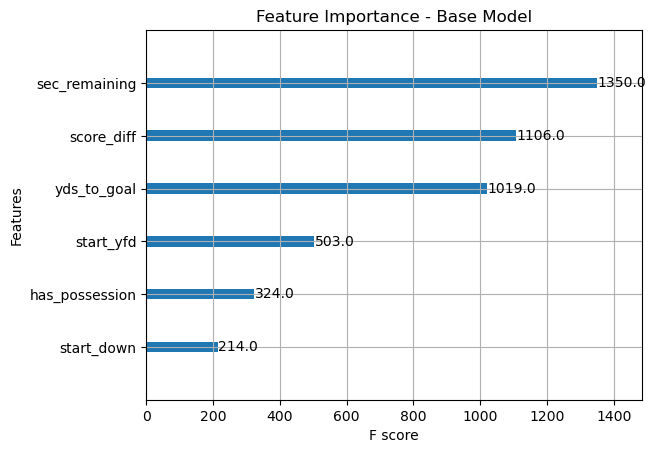


Training model: Base Model +
Log Loss: 0.3235, AUC-ROC: 0.9314

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82     51878
           1       0.85      0.87      0.86     68118

    accuracy                           0.84    119996
   macro avg       0.84      0.84      0.84    119996
weighted avg       0.84      0.84      0.84    119996



<Figure size 900x700 with 0 Axes>

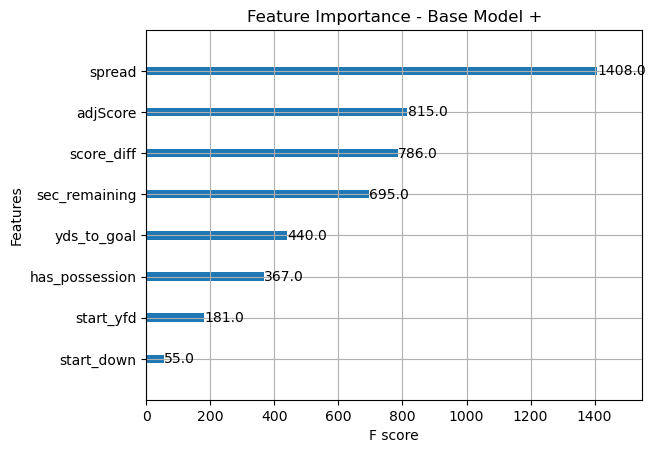


Training model: Full Model
Log Loss: 0.1423, AUC-ROC: 0.9945

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     51878
           1       0.96      0.97      0.97     68118

    accuracy                           0.96    119996
   macro avg       0.96      0.96      0.96    119996
weighted avg       0.96      0.96      0.96    119996



<Figure size 900x700 with 0 Axes>

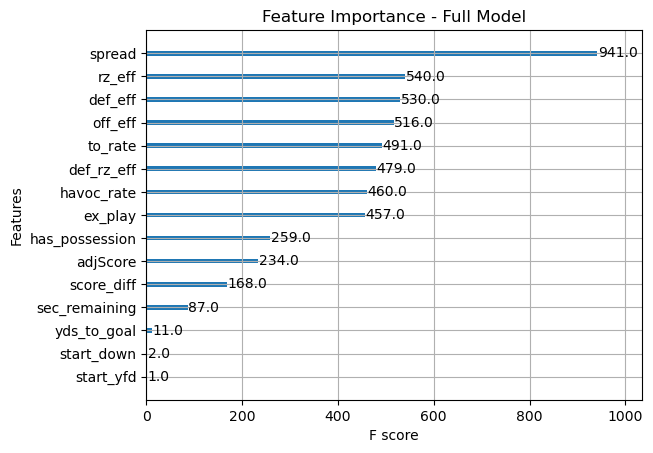

          Model  Log Loss   AUC-ROC
0    Base Model  0.421934  0.876840
1  Base Model +  0.323511  0.931449
2    Full Model  0.142271  0.994542


In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import log_loss, roc_auc_score, classification_report

data = master_dataset[master_dataset['week'] > 3].copy()

# Define feature sets for comparison
feature_sets = {
    "Base Model": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd'],
    "Base Model +": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd', 'adjScore', 'spread'],
    "Full Model": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd', 'adjScore', 'spread', 'off_eff', 'rz_eff', 'to_rate', 'ex_play', 'def_eff', 'def_rz_eff', 'havoc_rate']
}

# Dictionary to store results
results = []
models = {}

for name, features in feature_sets.items():
    print(f"\nTraining model: {name}")

    # Define X and y
    X = data[features]
    y = data['outcome']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Train XGBoost model
    model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        reg_lambda=1.0,  # L2 regularization
        reg_alpha=0.5  # L1 regularization
    )
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = np.clip(model.predict_proba(X_test)[:, 1], 1e-12, 0.9999999)

    # Convert probabilities to binary predictions
    y_pred_class = (y_pred_proba > 0.5).astype(int)

    # Evaluate performance
    log_loss_score = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"Log Loss: {log_loss_score:.4f}, AUC-ROC: {auc_score:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class))

    # Store results
    results.append({"Model": name, "Log Loss": log_loss_score, "AUC-ROC": auc_score})
    
    models[name] = model
    
    # Plot feature importance
    plt.figure(figsize=(9, 7))
    plot_importance(model, importance_type='weight')
    plt.title(f"Feature Importance - {name}")
    plt.show()

# Convert results to a DataFrame
full_wp_model = model
results_df = pd.DataFrame(results)
print(results_df)


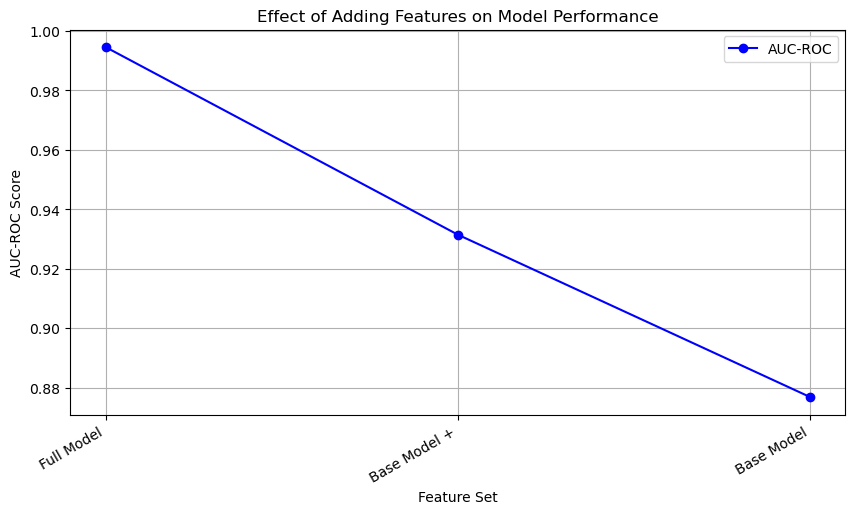

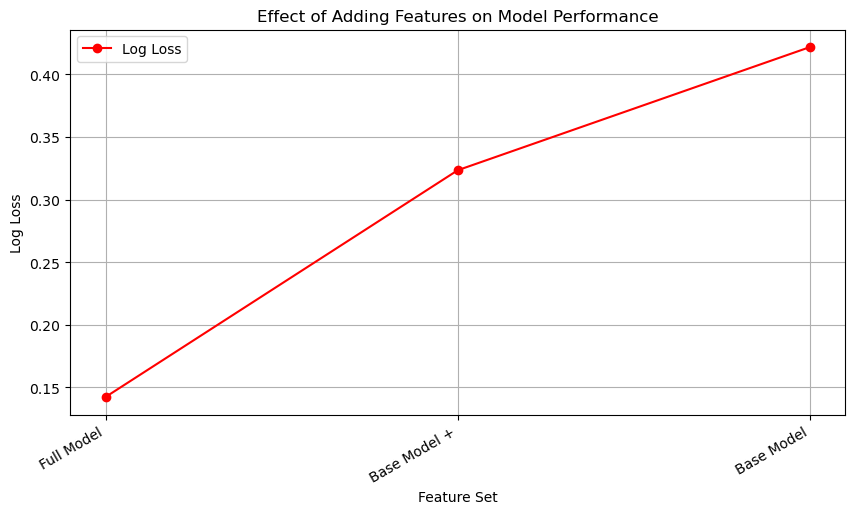

In [196]:
import matplotlib.pyplot as plt

# Sort models by AUC-ROC score
results_df = results_df.sort_values(by="AUC-ROC", ascending=False)

# Plot AUC-ROC
plt.figure(figsize=(10,5))
plt.plot(results_df["Model"], results_df["AUC-ROC"], marker='o', label="AUC-ROC", color='b')
plt.xlabel("Feature Set")
plt.ylabel("AUC-ROC Score")
plt.title("Effect of Adding Features on Model Performance")
plt.xticks(rotation=30, ha="right")
plt.grid()
plt.legend()
plt.show()

# Plot Log Loss
plt.figure(figsize=(10,5))
plt.plot(results_df["Model"], results_df["Log Loss"], marker='o', label="Log Loss", color='r')
plt.xlabel("Feature Set")
plt.ylabel("Log Loss")
plt.title("Effect of Adding Features on Model Performance")
plt.xticks(rotation=30, ha="right")
plt.grid()
plt.legend()
plt.show()

In [197]:
def predict_win_probability(model, game_state):

    # Convert game_state to DataFrame
    game_state_df = pd.DataFrame([game_state])

    # Ensure columns match model training features exactly
    game_state_df = game_state_df[X.columns]  # Reorders columns to match X during training

    # Predict win probability
    win_prob = model.predict_proba(game_state_df)[:, 1][0]

    return win_prob

def gs_play_change(game_state, old_type, new_type):
    gs = game_state
    gs[f"play_type_{old_type}"] = False
    gs[f"play_type_{new_type}"] = True
    return gs

Processing Base Model...
Processing Base Model +...
Processing Full Model...


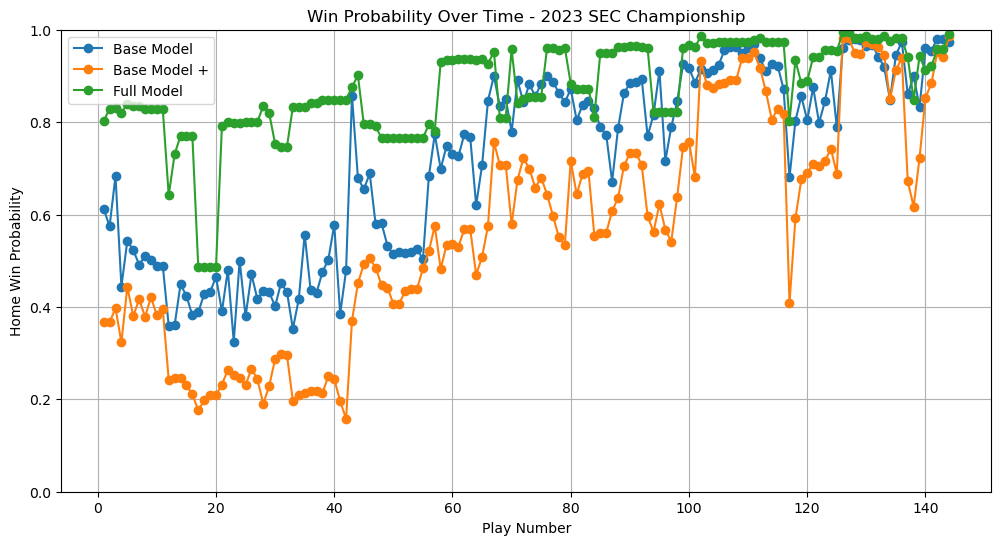

In [198]:
import matplotlib.pyplot as plt

# Define the game to analyze
game_id = '2023_Georgia@Alabama_14'

# Filter data for the selected game
game_data = data[data['match'] == game_id].copy()

# Sort plays in chronological order (earliest plays first)
game_data = game_data.sort_values(by=['quarter', 'sec_remaining'], ascending=[True, False])

# Create a play number column to track the sequence of plays
game_data['play_number'] = range(1, len(game_data) + 1)

# Dictionary to store predictions from each model
wp_predictions = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")

    # Get the correct feature set for this model
    required_features = feature_sets[model_name]

    # Ensure all required features exist in game_data (fill missing with 0)
    for feature in required_features:
        if feature not in game_data.columns:
            game_data[feature] = 0

    # Select only the columns required for this model
    X_game = game_data[required_features]

    # Predict win probabilities in batch (vectorized, no loop needed)
    game_data['win_prob'] = np.clip(model.predict_proba(X_game)[:, 1], 1e-12, 0.9999999)

    # Store predictions for later plotting
    wp_predictions[model_name] = game_data['win_prob'].values

# Plot all models' win probability curves
plt.figure(figsize=(12, 6))

for model_name, wp_values in wp_predictions.items():
    plt.plot(game_data['play_number'], wp_values, marker='o', linestyle='-', label=model_name)

# Formatting the plot
plt.xlabel("Play Number")
plt.ylabel("Home Win Probability")
plt.title(f"Win Probability Over Time - 2023 SEC Championship")
plt.ylim(0, 1)  # Ensure WP stays between 0 and 1
plt.grid(True)
plt.legend()
plt.show()


In [199]:
data_temp = data

In [200]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features = [
    'sec_remaining', 'score_diff',
    'start_yard_line', 'yds_to_goal', 'start_down', 'start_yfd',
    'adjScore',
    'play_type_conversion', 'play_type_extra_point', 'play_type_field_goal',
    'play_type_pass', 'play_type_penalty',
    'play_type_punt', 'play_type_rush',
    # Efficiency metrics added
    'off_eff', 'rz_eff', 'to_rate', 'ex_play',
    'def_eff', 'def_rz_eff', 'havoc_rate'
] 

# Drop NaN rows (important for modeling)
#data_temp = data_temp.dropna(subset=features + ['points_scored_drive'])

# Fill NaN values in existing points_scored column
data_temp['points_scored'] = data_temp['points_scored'].fillna(0)

# Sort dataset by match, drive_id, and sec_remaining (descending order)
data_temp = data_temp.sort_values(by=['match', 'sec_remaining'], ascending=[True, False])

# Split data_temp into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_temp[features], data_temp['points_scored_drive'], test_size=0.2, random_state=42
)

# Train XGBoost model for EP prediction
xgb_model = XGBRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict Expected Points (EP)
data_temp['predicted_ep'] = xgb_model.predict(data_temp[features])

# Calculate EPA with points scored and possession change logic

def calculate_epa_with_possession(df):
    df['next_ep'] = df.groupby('match')['predicted_ep'].shift(-1)
    df['possession_change'] = df['start_team'] != df['end_team']

    # Base EPA: Next EP - Current EP + Points Scored
    df['epa'] = df['next_ep'] - df['predicted_ep'] + df['points_scored']

    # For possession change, need to subtract next_ep twice (once implicit, once explicit)
    df.loc[df['possession_change'], 'epa'] -= df.loc[df['possession_change'], 'next_ep']

    # If there's a possession change, subtract the next EP to reflect opponent opportunity
    df.loc[df['possession_change'], 'epa'] -= df.loc[df['possession_change'], 'next_ep']  # Already subtracts once, adjust total subtraction below

    df['epa'].fillna(0, inplace=True)
    return df

# Apply the EPA calculation
data_temp = calculate_epa_with_possession(data_temp)


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\3395637369.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['epa'].fillna(0, inplace=True)


ROC AUC: 0.700124062928941


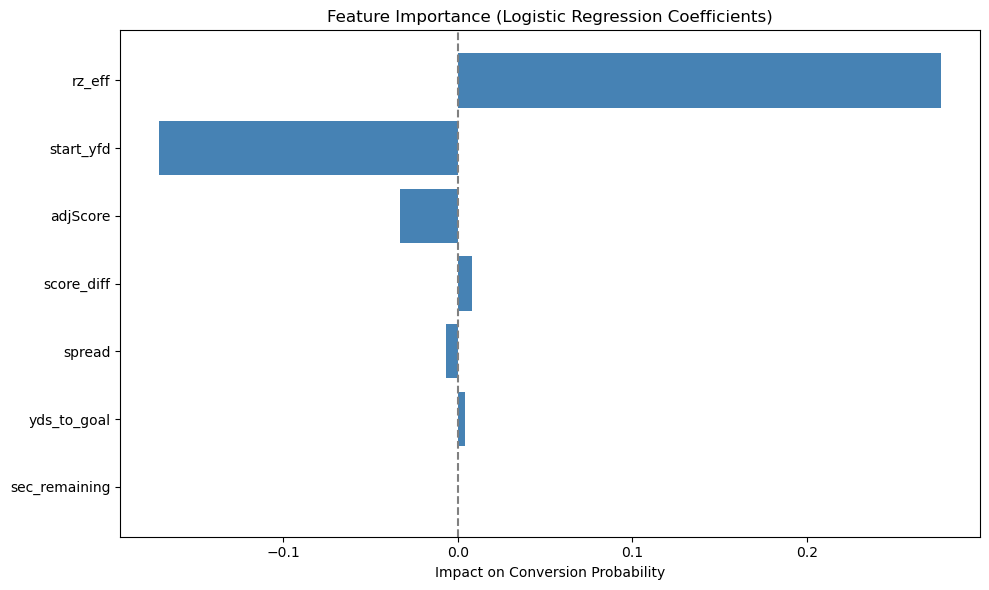

In [201]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Define features to use (Option 2)
fd_features = [
    'sec_remaining', 'score_diff', 'yds_to_goal', 'start_yfd', 'adjScore', 'spread', 'rz_eff',
]

# Filter to 4th down scrimmage plays and calculate conversion
fourth_down_df = data[(data['start_down'] == 4) & (data['play_type_scrimmage'] == 1)].copy()
fourth_down_df['conversion'] = ((fourth_down_df['pass_yds'] + fourth_down_df['rush_yds']) >= fourth_down_df['start_yfd']).astype(int)

# Drop rows with missing values in selected features
fourth_down_df.dropna(subset=fd_features, inplace=True)

# Prepare features and target
X = fourth_down_df[fd_features]
y = fourth_down_df['conversion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model with L2 regularization
fd_conversion_model = LogisticRegression(max_iter=1000, penalty='l2', C=0.5)
fd_conversion_model.fit(X_train, y_train)

# Predict probabilities for all plays
fourth_down_df['conversion_prob'] = fd_conversion_model.predict_proba(X)[:, 1]

# Evaluate model performance
y_pred = fd_conversion_model.predict(X_test)
y_proba = fd_conversion_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Plot feature importance
coef_df = pd.DataFrame({
    'Feature': fd_features,
    'Coefficient': fd_conversion_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='steelblue')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Impact on Conversion Probability')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [202]:
# Bin by distance to go (start_yfd) - you can adjust the bin width if needed
fourth_down_df['distance_bin'] = pd.cut(fourth_down_df['start_yfd'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 100])

# Compute actual historical conversion rates per bin
conversion_by_bin = fourth_down_df.groupby('distance_bin')['conversion'].mean().reset_index()
conversion_by_bin.rename(columns={'conversion': 'actual_conversion_rate'}, inplace=True)

# Compute model average predicted probability per bin
model_prob_by_bin = fourth_down_df.groupby('distance_bin')['conversion_prob'].mean().reset_index()
model_prob_by_bin.rename(columns={'conversion_prob': 'model_avg_conversion_prob'}, inplace=True)

# Merge them for side-by-side comparison
comparison_df = conversion_by_bin.merge(model_prob_by_bin, on='distance_bin')

print(comparison_df)

   distance_bin  actual_conversion_rate  model_avg_conversion_prob
0        (0, 1]                0.685157                   0.642302
1        (1, 2]                0.549639                   0.594748
2        (2, 3]                0.500000                   0.550064
3        (3, 4]                0.495987                   0.507454
4        (4, 5]                0.397463                   0.459077
5        (5, 6]                0.361650                   0.420759
6        (6, 7]                0.398119                   0.375098
7        (7, 8]                0.317597                   0.332824
8        (8, 9]                0.281553                   0.294735
9       (9, 10]                0.280116                   0.286441
10     (10, 15]                0.221095                   0.193824
11    (15, 100]                0.103774                   0.075620


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\589071405.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_by_bin = fourth_down_df.groupby('distance_bin')['conversion'].mean().reset_index()
C:\Users\12246\AppData\Local\Temp\ipykernel_51548\589071405.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_prob_by_bin = fourth_down_df.groupby('distance_bin')['conversion_prob'].mean().reset_index()


In [203]:
sample_size_by_bin = fourth_down_df.groupby('distance_bin').size().reset_index(name='num_samples')

print(sample_size_by_bin)

   distance_bin  num_samples
0        (0, 1]         2614
1        (1, 2]         1108
2        (2, 3]          776
3        (3, 4]          623
4        (4, 5]          473
5        (5, 6]          412
6        (6, 7]          319
7        (7, 8]          233
8        (8, 9]          206
9       (9, 10]          689
10     (10, 15]          493
11    (15, 100]          318


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\3167915353.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_size_by_bin = fourth_down_df.groupby('distance_bin').size().reset_index(name='num_samples')


In [204]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Example: Filter your data for FG attempts
fg_df = data[data['play_type_field_goal'] == 1].copy()
fg_df['fg_distance'] = fg_df['yds_to_goal'] + 17
fg_df = fg_df[fg_df['fg_distance'] < 65]

# Define sigmoid function
def sigmoid(x, a, b):
    return 1 / (1 + np.exp(a * (x - b)))

# Fit curve to the actual makes/misses
params, _ = curve_fit(sigmoid, fg_df['fg_distance'], fg_df['fg_made'], p0=[0.1, 45])

print(f"Fitted parameters: a = {params[0]}, b = {params[1]}")


Fitted parameters: a = 0.08636782442135364, b = 50.48736753506932


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\3464252819.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_summary = fg_df.groupby('distance_bin').agg(


   distance_bin  actual_make_rate  predicted_make_rate  attempts
0      [20, 21)          0.948454             0.932963        97
1      [21, 22)          0.955414             0.927356       157
2      [22, 23)          0.940397             0.921318       151
3      [23, 24)          0.902439             0.914825       164
4      [24, 25)          0.924419             0.907850       172
5      [25, 26)          0.883598             0.900365       189
6      [26, 27)          0.917949             0.892345       195
7      [27, 28)          0.897727             0.883762       176
8      [28, 29)          0.906250             0.874592       160
9      [29, 30)          0.891720             0.864809       157
10     [30, 31)          0.874251             0.854389       167
11     [31, 32)          0.832487             0.843312       197
12     [32, 33)          0.783069             0.831559       189
13     [33, 34)          0.814815             0.819112       189
14     [34, 35)          

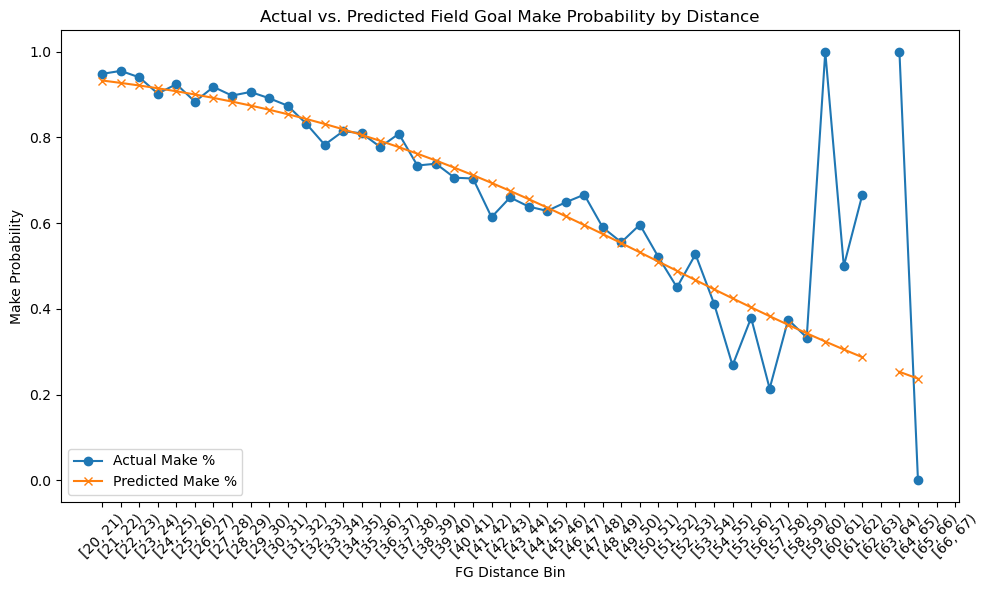

In [205]:
# First, add predicted FG probability to the dataframe
fg_df['fg_prob_pred'] = sigmoid(fg_df['fg_distance'], *params)

# Bin distances into 5-yard buckets
fg_df['distance_bin'] = pd.cut(fg_df['fg_distance'], bins=range(20, 71, 1), right=False)

# Group by bin and calculate actual & predicted make rate
binned_summary = fg_df.groupby('distance_bin').agg(
    actual_make_rate=('fg_made', 'mean'),
    predicted_make_rate=('fg_prob_pred', 'mean'),
    attempts=('fg_made', 'count')
).reset_index()

# Print or display the summary table
print(binned_summary)

# Optional: Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(binned_summary['distance_bin'].astype(str), binned_summary['actual_make_rate'], label='Actual Make %', marker='o')
plt.plot(binned_summary['distance_bin'].astype(str), binned_summary['predicted_make_rate'], label='Predicted Make %', marker='x')
plt.xticks(rotation=45)
plt.xlabel('FG Distance Bin')
plt.ylabel('Make Probability')
plt.title('Actual vs. Predicted Field Goal Make Probability by Distance')
plt.legend()
plt.tight_layout()
plt.show()


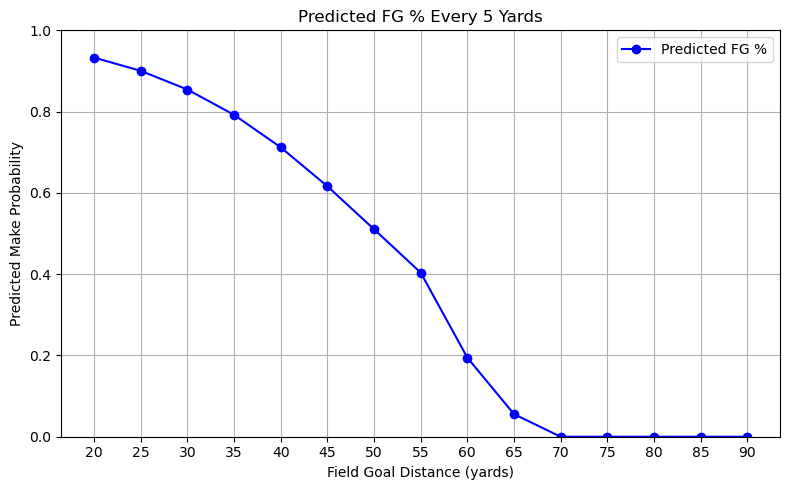

Sigmoid Model ROC-AUC: 0.720


In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import roc_auc_score

# Define sigmoid function
sigmoid = lambda x, a, b: 1 / (1 + np.exp(a * (x - b)))

# Fit sigmoid to actual FG outcomes
sig_params, _ = curve_fit(sigmoid, fg_df['fg_distance'], fg_df['fg_made'], p0=[0.1, 45])

# Predict base sigmoid probability
fg_df['sigmoid_pred_prob'] = sigmoid(fg_df['fg_distance'], *sig_params)

# Define adjustment for longer kicks (58+ yards)
def adjust_fg_prob(distance, base_prob):
    if distance < 58:
        return base_prob
    elif distance >= 67:
        return 0.0
    else:
        return max(0.25 * (67 - distance) / (67 - 58), 0)

# Apply adjustment row-wise
fg_df['sigmoid_pred_prob'] = fg_df.apply(
    lambda row: adjust_fg_prob(row['fg_distance'], row['sigmoid_pred_prob']),
    axis=1
)

# Generate predicted probabilities every 5 yards (with adjusted logic)
yard_lines = np.arange(20, 91, 5)
predicted_probs = []

for y in yard_lines:
    base = sigmoid(y, *sig_params)
    adj = adjust_fg_prob(y, base)
    predicted_probs.append(adj)

# Plot the predicted FG percentage at each 5-yard interval
plt.figure(figsize=(8, 5))
plt.plot(yard_lines, predicted_probs, marker='o', linestyle='-', color='blue', label='Predicted FG %')
plt.xticks(yard_lines)
plt.xlabel('Field Goal Distance (yards)')
plt.ylabel('Predicted Make Probability')
plt.title('Predicted FG % Every 5 Yards')
plt.grid(True)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# ROC-AUC for sigmoid prediction
roc_auc_sigmoid = roc_auc_score(fg_df['fg_made'], fg_df['sigmoid_pred_prob'])
print(f"Sigmoid Model ROC-AUC: {roc_auc_sigmoid:.3f}")

In [207]:
from scipy.stats import gaussian_kde
import numpy as np

punt_df = data[data['play_type_punt'] == 1].copy()
punt_df['resulting_fp'] = 100 - (punt_df['yds_to_goal'] - punt_df['punt_net_yds'])

# Precompute normal model for deep punts (own 0 to own 45)
deep_punts = punt_df[punt_df['yds_to_goal'] >= 55]
deep_mean = deep_punts['punt_net_yds'].mean()
deep_std = deep_punts['punt_net_yds'].std()

# Precompute KDE for gray area punts (own 40 or closer)
gray_punts = punt_df[punt_df['yds_to_goal'] < 55].copy()
kde_gray = gaussian_kde(gray_punts['resulting_fp'])

# Punt simulation function
def simulate_punt_outcome(punt_yardline):
    """
    Simulate a punt outcome based on starting yardline.
    - If punt is from own 0 to own 45 (100 to 55 yards from goal), use Normal
    - If punt is from opponent 45 or closer (under 55 yards from goal), use KDE
    Returns: opponent starting yardline after punt
    """

    if punt_yardline >= 55:
        # Deep punt modeled as normal distribution
        resulting_fp = 100 - (punt_yardline - np.random.normal(deep_mean, deep_std))
    if (punt_yardline < 55) & (punt_yardline > 40):
        # Gray area punt modeled with KDE
        resulting_fp = kde_gray.resample(1).flatten()[0]
    if punt_yardline <= 40:
        resulting_fp = 88 

    # Calculate opponent's starting field position
    return resulting_fp


In [208]:
# Helper functions

adv_stats = ['off_eff', 'rz_eff', 'to_rate', 'ex_play', 'def_eff', 'def_rz_eff', 'havoc_rate']

def next_or_prev_play_adv_stats(current_idx):
    current_match = data.loc[current_idx, 'match']
    current_possession = data.loc[current_idx, 'has_possession']

    # Look forward for next possession by the other team
    for i in range(current_idx + 1, len(data)):
        if data.loc[i, 'match'] != current_match:
            break
        if data.loc[i, 'has_possession'] != current_possession:
            return i, data.loc[i, adv_stats]

    # Look backward in case it's the last play or end of game
    for i in range(current_idx - 1, -1, -1):
        if data.loc[i, 'match'] != current_match:
            break
        if data.loc[i, 'has_possession'] == current_possession:
            return i, data.loc[i, adv_stats]

    return None, pd.Series({stat: np.nan for stat in adv_stats})


def simulate_expected_punt_result(punt_yardline, num_samples=100):
    opponent_starts = [simulate_punt_outcome(punt_yardline) for _ in range(num_samples)]
    
    # Calculate the expected opponent starting position as yards to goal
    expected_yds_to_goal = np.mean([opp_start for opp_start in opponent_starts])
    
    return expected_yds_to_goal


def update_game_state(current_state, feature_updates, poss_change):
    # Make a copy to avoid mutating the original
    final_state = current_state.copy()
    
    # Apply the feature updates dynamically
    for key, value in feature_updates.items():
        # If the update value is callable (function), execute it
        if callable(value):
            final_state[key] = value()
        else:
            final_state[key] = value

    # Safely handle possession flipping
    has_poss = current_state['has_possession'] if not isinstance(current_state['has_possession'], pd.Series) else current_state['has_possession'].item()
    
    if poss_change:
        final_state['has_possession'] = 1 - has_poss  # Flip possession

    return final_state

C:\Users\12246\AppData\Local\Temp\ipykernel_51548\304402957.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  actual_ytg_by_bin = punt_df.groupby('start_bin')['expected_ytg_actual'].mean().reset_index()


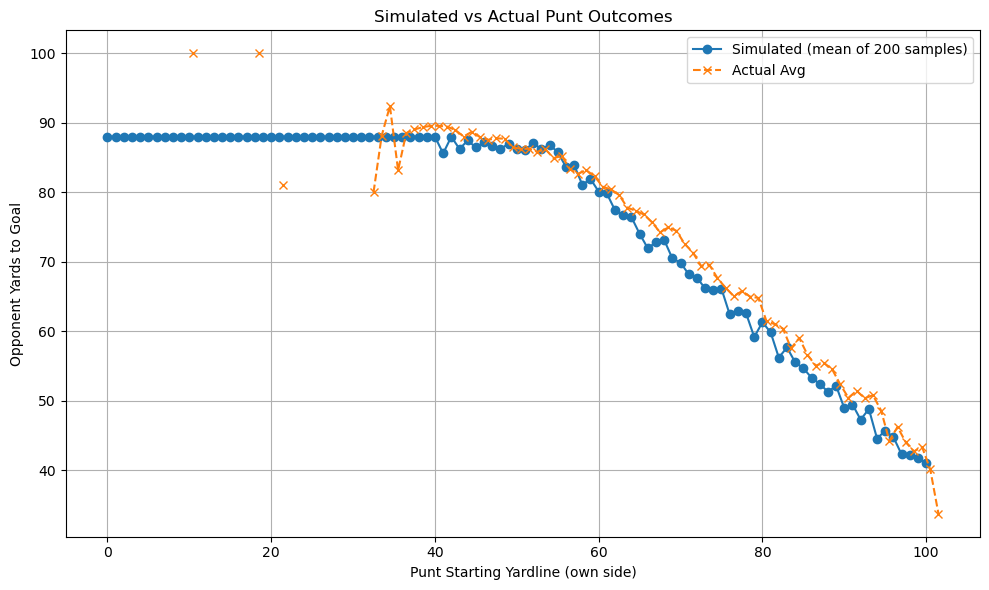

In [209]:
yardlines = np.arange(0, 101, 1)
expected_ytg = [simulate_expected_punt_result(y, num_samples=200) for y in yardlines]

# Calculate actual expected opponent field position from real punts
punt_df['expected_ytg_actual'] = 100 - (punt_df['yds_to_goal'] - punt_df['punt_net_yds'])
punt_df['expected_ytg_actual'] = punt_df['expected_ytg_actual'].clip(0, 100)

# Bin punts by intervals
punt_df['start_bin'] = pd.cut(punt_df['yds_to_goal'], bins=yardlines, right=False)

# Compute average actual opponent ytg per bin
actual_ytg_by_bin = punt_df.groupby('start_bin')['expected_ytg_actual'].mean().reset_index()
actual_ytg_by_bin['bin_center'] = actual_ytg_by_bin['start_bin'].apply(lambda x: x.left + 2.5)

# Plot simulated vs. actual punt outcomes
plt.figure(figsize=(10, 6))
plt.plot(yardlines, expected_ytg, marker='o', linestyle='-', label='Simulated (mean of 200 samples)')
plt.plot(actual_ytg_by_bin['bin_center'], actual_ytg_by_bin['expected_ytg_actual'],
         marker='x', linestyle='--', label='Actual Avg')
plt.xlabel("Punt Starting Yardline (own side)")
plt.ylabel("Opponent Yards to Goal")
plt.title("Simulated vs Actual Punt Outcomes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

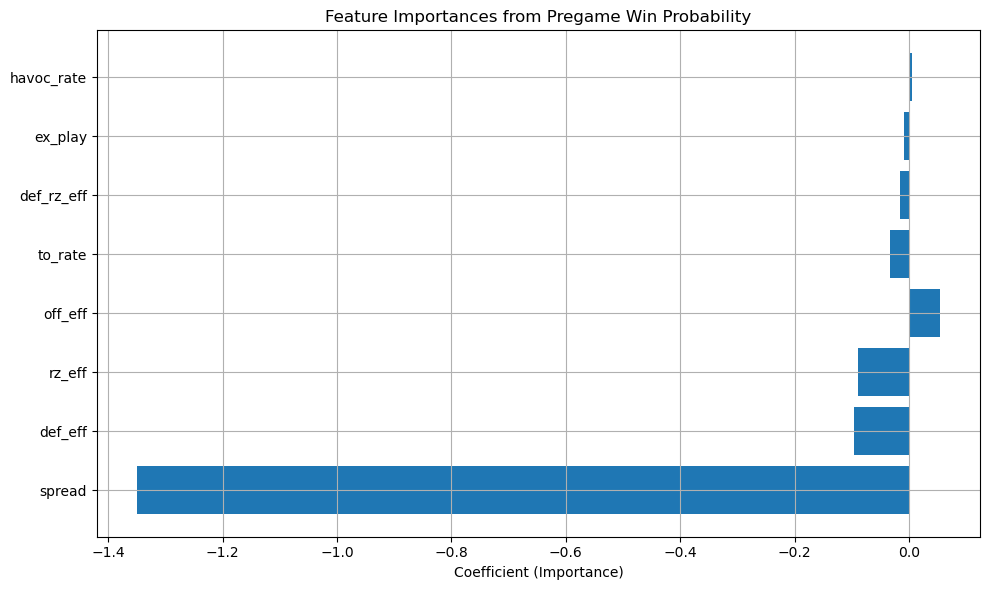

In [210]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Sort so that first play per match is on top
data = data.sort_values(by=['match', 'sec_remaining'], ascending=[True, False]).reset_index(drop=True)

# Step 1: Filter first plays
first_plays = data.groupby('match').head(1).copy()

# Step 2: Flip spread if needed
first_plays['spread'] = first_plays.apply(
    lambda row: -row['spread'] if row['has_possession'] == 0 else row['spread'],
    axis=1
)

# Step 3: Define features and outcome
fp_features = ['spread', 'off_eff', 'rz_eff', 'to_rate', 
               'ex_play', 'def_eff', 'def_rz_eff', 'havoc_rate']
X = first_plays[fp_features]
y = first_plays['outcome']

# Step 4: Remove rows with missing values
mask = X.notna().all(axis=1) & y.notna()
X_clean = X[mask]
y_clean = y[mask]

# Step 5: Standardize and fit logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

model = LogisticRegression()
model.fit(X_scaled, y_clean)

# Step 6: Predict and assign home win probability
first_plays.loc[X_clean.index, 'home_win_prob'] = model.predict_proba(X_scaled)[:, 1]

# Step 7: Select only columns we want to merge back
update_cols = ['match', 'home_win_prob']
first_plays_update = first_plays[update_cols]

# Step 8: Merge back into full dataset
data = data.merge(first_plays_update, on='match', how='left')

# Step 9: Print feature importances
feature_importance = pd.DataFrame({
    'feature': fp_features,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

# Step 10: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.xlabel('Coefficient (Importance)')
plt.title('Feature Importances from Pregame Win Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

In [211]:
data.head()

,play_id,year,week,neutral_site,attendance,quarter,score_points,start_yard_line,start_down,start_yfd,end_yard_line,end_down,end_yfd,pass_att,pass_cmp,pass_yds,pass_sk,pass_sk_yds,pass_td,pass_int,pass_fd,pass_rz_att,pass_sfty,rec_tar,rec_rec,rec_yds,rec_td,rec_fd,rec_rz_tar,rec_sfty,rush_att,rush_yds,rush_td,rush_fd,rush_rz_att,rush_sfty,rush_tlost,rush_tlost_yards,fg_att,fg_made,fg_miss,fg_yds,fg_blk,xp_att,xp_made,xp_missed,two_pt_att,two_pt_cmp,misc_yards,pen_yds,pen_count,def_tlost,def_ast_tlost,def_tlost_yds,def_sack,def_ast_sack,def_sack_yds,def_sfty,def_int,def_int_yds,def_int_td,def_force_fum,def_qb_hit,def_pass_defended,def_block,kickoffs_kicks,kickoffs_yds,kickoffs_gross_yds,kickoffs_net_yds,kickoffs_endzone,kickoffs_in20,kickoffs_tb,kick_ret_returns,kick_ret_yds,kick_ret_fc,kick_ret_td,kick_ret_type,kick_ret_tb,kick_ret_oob,punt_punts,punt_yds,punt_net_yds,punt_blk,punt_in20,punt_tb,fumb_fum,fumb_forced,fumb_lost,fumb_oob,fum_ret_own_rec,fum_ret_opp_rec,fum_ret_opp_rec_yds,fum_ret_own_rec_yds,fum_ret_opp_rec_td,fum_ret_own_rec_td,block_block,sec_remaining,outcome,yds_to_goal,scheduled_date,home_abbr,home_market,home_name,away_abbr,away_market,away_name,position,start_clock,summary,start_team,start_side,end_team,end_side,penalty_responsible,home_pts,away_pts,score_diff,spread,match,hcgamescoached,hcgameswon,hcfirstname,hclastname,v16,acgamescoached,acgameswon,acfirstname,aclastname,has_possession,adjScore,drive_id,off_eff,rz_eff,to_rate,ex_play,def_eff,def_rz_eff,havoc_rate,points_scored,points_scored_drive,goal_to_go,play_type_conversion,play_type_extra_point,play_type_field_goal,play_type_kickoff,play_type_pass,play_type_penalty,play_type_punt,play_type_rush,play_type_scrimmage,team_market,home_win_prob
0,115690,2021,7,NaN,34446,1,NaN,35,1,10,31,2,10,1,1,6,0,0,0,0,0,0,0,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3600.0,0,75,10/17/2021,BOISE,Boise State,Broncos,AF,Air Force,Falcons,WR,15:00,H.Bachmeier pass complete to BOISE 25. Catch m...,BOISE,BOISE,BOISE,BOISE,NaN,0,0,0,-3.0,2021_Air Force@Boise State_7,12,7,Andy,Avalos,NaN,13,10,Troy,Calhoun,1,0.0,175.0,0.340909,0.84,0.022039,0.074380,0.764706,0.2,0.081081,0.0,7,0,False,False,False,False,True,False,False,False,1,NaN,0.567662
1,115688,2021,7,NaN,34446,1,NaN,31,2,4,39,1,10,1,1,8,0,0,0,0,1,0,0,1,1,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3583.0,0,69,10/17/2021,BOISE,Boise State,Broncos,AF,Air Force,Falcons,WR,14:43,H.Bachmeier pass complete to BOISE 31. Catch m...,BOISE,BOISE,BOISE,BOISE,NaN,0,0,0,-3.0,2021_Air Force@Boise State_7,12,7,Andy,Avalos,NaN,13,10,Troy,Calhoun,1,0.0,175.0,0.340909,0.84,0.021978,0.074176,0.764706,0.2,0.080838,0.0,7,0,False,False,False,False,True,False,False,False,1,NaN,0.567662
2,115684,2021,7,NaN,34446,1,NaN,39,1,10,43,2,6,1,1,4,0,0,0,0,0,0,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3553.0,0,61,10/17/2021,BOISE,Boise State,Broncos,AF,Air Force,Falcons,RB,14:13,H.Bachmeier pass complete to BOISE 39. Catch m...,BOISE,BOISE,BOISE,BOISE,NaN,0,0,0,-3.0,2021_Air Force@Boise State_7,12,7,Andy,Avalos,NaN,13,10,Troy,Calhoun,1,0.0,175.0,0.340909,0.84,0.021918,0.073973,0.764706,0.2,0.080597,0.0,7,0,False,False,False,False,True,False,False,False,1,NaN,0.567662
3,115678,2021,7,NaN,34446,1,NaN,43,2,6,45,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3523.0,0,57,10/17/2021,BOISE,Boise State,Broncos,AF,Air Force,Falcons,RB,13:43,A.Van Buren rushed to BOISE 45 for 2 yards. Ta...,BOISE,BOISE,BOISE,BOISE,NaN,0,0,0,-3.0,2021_Air Force@Boise State_7,12,7,Andy,Avalos,NaN,13,10,Troy,Calhoun,1,0.0,175.0,0.340909,0.84,0.021858,0.073770,0

In [212]:
all_fd = data[data['start_down'] == 4].copy()

features = ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd', 'adjScore', 'spread', 'off_eff', 'rz_eff', 'to_rate', 'ex_play', 'def_eff', 'def_rz_eff', 'havoc_rate']

all_fd['situation'] = all_fd.apply(
    lambda row: f"4th & {int(row['start_yfd'])}, {int(row['yds_to_goal'])} yds to goal, {int(row['sec_remaining'])} sec left, {row['has_possession']} (poss), {row['score_diff']} score diff.",
    axis=1
)

all_fd.dropna(subset=['off_eff', 'rz_eff', 'def_eff', 'def_rz_eff'], inplace=True)
# Predict conversion probability for a new scenario
#all_fd['conversion_prob'] = fd_conversion_model.predict_proba(all_fd[features])[:, 1]

In [213]:
def plot_binned(all_fd, label):

    # Step 1: Create 5-yard bins for yds_to_goal
    bin_edges = list(range(0, 105, 5))  # 0 to 100 yards, step 5
    all_fd['yard_bin'] = pd.cut(all_fd['yds_to_goal'], bins=bin_edges, right=False)

    # Step 2: Group by yard bin and count optimal decisions
    binned_optimal = all_fd.groupby(['yard_bin', f'{label}_optimal_choice']).size().unstack(fill_value=0)

    # Step 3: Print the binned counts
    print(f"\nOptimal Decision Counts by Field Position - {label}:")
    #print(binned_optimal)

    # Step 4 (Optional): Normalize to percentages within each bin
    binned_optimal_percent = binned_optimal.div(binned_optimal.sum(axis=1), axis=0) * 100
    print(f"\nOptimal Decision Percentages by Field Position - {label}")
    print(binned_optimal_percent.round(2))

    # Step 5 (Optional): Plotting - Stacked Bar Chart of Model Decision by Field Position
    binned_optimal.plot(kind='bar', stacked=True, figsize=(12,6), color=['green', 'blue', 'orange'])
    plt.title(f'Model Optimal Decisions by Field Position - {label}')
    plt.xlabel('Yards to Goal')
    plt.ylabel('Number of Plays')
    plt.legend(title='Decision')
    plt.tight_layout()
    plt.show()

In [214]:
fg_make_updates = []
fg_miss_updates = []

# FG prob. prediction section
all_fd['fg_prob'] = sigmoid(all_fd['yds_to_goal'] + 17, *sig_params)
all_fd['fg_prob'] = all_fd.apply(
    lambda row: adjust_fg_prob(row['yds_to_goal'] + 17, row['fg_prob']),
    axis=1
)

all_fd['conversion_prob'] = fd_conversion_model.predict_proba(all_fd[fd_features])[:, 1]

In [215]:
# Now calculating EWP and Optimal Choices for every model
all_fd_WP = all_fd.copy()

feature_sets = {
    "Base Model": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd'],
    "Base Model +": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd', 'adjScore', 'spread'],
    "Full Model": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd', 'adjScore', 'spread', 'off_eff', 'rz_eff', 'to_rate', 'ex_play', 'def_eff', 'def_rz_eff', 'havoc_rate']
}

def time_score_update(sec_left, score_diff):
    new_time = max(sec_left - 5, 0)
    adjScore = -score_diff / np.sqrt(new_time+1)
    return new_time, adjScore

for model_name, model in models.items():
    print(f"Processing: {model_name}")
    bmp_features = feature_sets[model_name]

    punt_updates, fg_make_updates, fg_miss_updates = [], [], []
    go_success_updates, go_fail_updates = [], []

    for idx, row in all_fd_WP.iterrows():
        if model_name == "Full Model":
            _, adv_values = next_or_prev_play_adv_stats(idx)
        
        # --- Raw (unfiltered) decision logic will be preserved for regression ---
        raw_yds = row['yds_to_goal']
        raw_score_diff = row['score_diff']
        timeLeft = row['sec_remaining']

        # --- Skip obviously bad decisions based on field position intuition ---
        skip_fg = row['yds_to_goal'] > 50  # too far for a field goal
        skip_punt = row['yds_to_goal'] < 35  # too close for a punt

        # --- Punt Outcome ---
        new_time, adjScore = time_score_update(timeLeft, raw_score_diff)
        punt_yds_to_goal = simulate_expected_punt_result(raw_yds, num_samples=1)
        punt_update = row[bmp_features].copy()
        punt_update.update({
            'yds_to_goal': max(punt_yds_to_goal, 60),
            'start_down': 1,
            'start_yfd': 10,
            'has_possession': 1 - row['has_possession'],
            'sec_remaining': new_time,
            'score_diff': -raw_score_diff,
            'adjScore': adjScore,
        })
        
        if model_name == "Full Model":
            punt_update.update(adv_values.to_dict())
        punt_updates.append(punt_update)

        # --- FG Outcomes ---
        fg_score_diff = raw_score_diff + 3 if row['has_possession'] == 1 else raw_score_diff - 3
        fg_make_update = row[bmp_features].copy()
        new_time, adjScore = time_score_update(timeLeft, fg_score_diff)
        fg_make_update.update({
            'score_diff': -fg_score_diff,
            'yds_to_goal': 75,
            'start_down': 1,
            'start_yfd': 10,
            'has_possession': 1 - row['has_possession'],
            'sec_remaining': new_time,
            'adjScore': adjScore
        })
        
        if model_name == "Full Model":
            fg_make_update.update(adv_values.to_dict())
        fg_make_updates.append(fg_make_update)
        
        new_time, adjScore = time_score_update(timeLeft, raw_score_diff)
        fg_miss_update = row[bmp_features].copy()
        fg_miss_update.update({
            'yds_to_goal': 100 - raw_yds,
            'start_down': 1,
            'start_yfd': 10,
            'has_possession': 1 - row['has_possession'],
            'sec_remaining': timeLeft,
            'score_diff': -raw_score_diff,
            'adjScore': adjScore
        })
        
        if model_name == "Full Model":
            fg_miss_update.update(adv_values.to_dict())
        fg_miss_updates.append(fg_miss_update)

        # --- Go-for-it Outcomes ---
        new_yds_to_goal = max(raw_yds - row['start_yfd'], 1)
        success_update = row[bmp_features].copy()
        if row['goal_to_go'] == 1:
            go_score_diff = raw_score_diff + 7 if row['has_possession'] == 1 else raw_score_diff - 7
            new_time, adjScore = time_score_update(timeLeft, go_score_diff)
            success_update.update({
                'score_diff': -go_score_diff,
                'yds_to_goal': 75,
                'start_down': 1,
                'start_yfd': 10,
                'has_possession': 1 - row['has_possession'],
                'sec_remaining': timeLeft,
                'adjScore': adjScore
            })
        else:
            new_time, adjScore = time_score_update(timeLeft, raw_score_diff)
            success_update.update({
                'yds_to_goal': new_yds_to_goal,
                'start_down': 1,
                'start_yfd': 10,
                'sec_remaining': new_time,
                'adjScore': -adjScore
            })
            
        if model_name == "Full Model":
            success_update.update(adv_values.to_dict())
        go_success_updates.append(success_update)
        
        new_time, adjScore = time_score_update(timeLeft, raw_score_diff)
        fail_update = row[bmp_features].copy()
        fail_update.update({
            'has_possession': 1 - row['has_possession'],
            'start_down': 1,
            'start_yfd': 10,
            'yds_to_goal': 100 - raw_yds,
            'score_diff': -raw_score_diff,
            'sec_remaining': new_time,
            'adjScore': adjScore
            
        })
        
        if model_name == "Full Model":
            fail_update.update(adv_values.to_dict())
        go_fail_updates.append(fail_update)

    # Convert to DataFrames for prediction
    punt_df = pd.DataFrame(punt_updates)
    fg_make_df = pd.DataFrame(fg_make_updates)
    fg_miss_df = pd.DataFrame(fg_miss_updates)
    go_success_df = pd.DataFrame(go_success_updates)
    go_fail_df = pd.DataFrame(go_fail_updates)

    # Predict expected win probabilities
    all_fd_WP[f'{model_name}_punt_EWP_raw'] = model.predict_proba(punt_df)[:, 1]
    fg_make_wp = model.predict_proba(fg_make_df)[:, 1]
    fg_miss_wp = model.predict_proba(fg_miss_df)[:, 1]
    all_fd_WP[f'{model_name}_fg_EWP_raw'] = (all_fd['fg_prob'] * fg_make_wp) + ((1 - all_fd['fg_prob']) * fg_miss_wp)

    go_success_wp = model.predict_proba(go_success_df)[:, 1]
    go_fail_wp = model.predict_proba(go_fail_df)[:, 1]
    all_fd_WP[f'{model_name}_go_EWP_raw'] = (all_fd['conversion_prob'] * go_success_wp) + ((1 - all_fd['conversion_prob']) * go_fail_wp)

    # Copy raw values to filtered values (can overwrite filtered with logic if needed)
    all_fd_WP[f'{model_name}_punt_EWP_filt'] = all_fd_WP[f'{model_name}_punt_EWP_raw'].where(~(all_fd_WP['yds_to_goal'] < 35), np.nan)
    all_fd_WP[f'{model_name}_fg_EWP_filt'] = all_fd_WP[f'{model_name}_fg_EWP_raw'].where(~(all_fd_WP['yds_to_goal'] > 50), np.nan)
    all_fd_WP[f'{model_name}_go_EWP_filt'] = all_fd_WP[f'{model_name}_go_EWP_raw']

    # Determine optimal choice based on filtered recommendations
    def pick_optimal(row):
        raw_ewps = {
            'go_EWP': row.get(f'{model_name}_go_EWP_raw', np.nan),
            'fg_EWP': row.get(f'{model_name}_fg_EWP_raw', np.nan),
            'punt_EWP': row.get(f'{model_name}_punt_EWP_raw', np.nan)
        }
        
        filtered_ewps = {
            'go_EWP': row.get(f'{model_name}_go_EWP_filt', np.nan),
            'fg_EWP': row.get(f'{model_name}_fg_EWP_filt', np.nan),
            'punt_EWP': row.get(f'{model_name}_punt_EWP_filt', np.nan)
        }
        
        if row['has_possession'] == 1:
            raw_opt  = max(raw_ewps, key=lambda k: raw_ewps[k] if pd.notna(raw_ewps[k]) else -np.inf)
            filt_opt = max(filtered_ewps, key=lambda k: filtered_ewps[k] if pd.notna(filtered_ewps[k]) else -np.inf)
        else:
            raw_opt  = min(raw_ewps, key=lambda k: raw_ewps[k] if pd.notna(raw_ewps[k]) else np.inf)
            filt_opt = min(filtered_ewps, key=lambda k: filtered_ewps[k] if pd.notna(filtered_ewps[k]) else np.inf)

        return raw_opt, filt_opt
    
    all_fd_WP[[f'{model_name}_optimal_choice_raw', f'{model_name}_optimal_choice_filt']] = all_fd_WP.apply(
    pick_optimal, axis=1, result_type='expand'
    )

    print(f"{model_name} done!")



Processing: Base Model
Base Model done!
Processing: Base Model +
Base Model + done!
Processing: Full Model
Full Model done!


In [216]:
all_fd = all_fd_WP
# Step 1: Classify the actual coach decision based on play types
def classify_actual(row):
    if row['play_type_punt'] == 1:
        return 'punt_EWP'
    elif row['play_type_field_goal'] == 1:
        return 'fg_EWP'
    elif row['play_type_scrimmage'] == 1:
        return 'go_EWP'
    else:
        return 'unknown'

all_fd['actual_choice'] = all_fd.apply(classify_actual, axis=1)

In [217]:
# Merge using match + play_id as composite keys
cols_to_keep = ['match', 'play_id', 'Base Model_optimal_choice_raw', 'Base Model_optimal_choice_filt', 
                'Base Model +_optimal_choice_raw', 'Base Model +_optimal_choice_filt', 'Full Model_optimal_choice_raw',
                'Full Model_optimal_choice_filt', 'actual_choice']

all_fd_clean = all_fd[cols_to_keep].copy()

data_merged = data.merge(all_fd_clean, on=['match', 'play_id'], how='left')

In [218]:
data_merged['home_coach'] = data_merged['hcfirstname'].str.strip() + ' ' + data_merged['hclastname'].str.strip()
data_merged['away_coach'] = data_merged['acfirstname'].str.strip() + ' ' + data_merged['aclastname'].str.strip()

# Combine both home and away coach columns
all_coaches = pd.concat([data_merged['home_coach'], data_merged['away_coach']])

# Get unique names and sort for consistency
unique_coaches = all_coaches.dropna().unique()
unique_coaches.sort()

In [219]:
# Use outcome to define who won
first_plays['home_win'] = first_plays['outcome']
first_plays['away_win'] = 1 - first_plays['outcome']
first_plays['gc'] = 1

# Expected win for each side
first_plays['home_ex_wins'] = first_plays['home_win_prob']
first_plays['away_ex_wins'] = 1 - first_plays['home_win_prob']

cols_to_keep = ['match','play_id','home_win','away_win','home_ex_wins','away_ex_wins','gc']
first_plays_clean = first_plays[cols_to_keep].copy()

data = data_merged
data_merged = data.merge(first_plays_clean, on=['match', 'play_id'], how='left')
data = data_merged

In [220]:
data_test = data
cols_to_fill = ['home_win','away_win','home_ex_wins','away_ex_wins','gc']
data_test[cols_to_fill] = data_test[cols_to_fill].fillna(0)

In [221]:
data = data_test
data_test1 = data.copy()
data_test1 = data_test1[data_test1['actual_choice'] != "unknown"]

# List of model recommendation columns
model_cols = [
    'Base Model_optimal_choice_raw',
    'Base Model_optimal_choice_filt',
    'Base Model +_optimal_choice_raw',
    'Base Model +_optimal_choice_filt',
    'Full Model_optimal_choice_raw',
    'Full Model_optimal_choice_filt'
]

# Create a deviation column for each model
for col in model_cols:
    dev_col = col.replace('optimal_choice', 'deviation')

    # Aggressive error: coach went when model said don't
    aggressive = (
        (~data_test1['actual_choice'].isna()) &
        (data_test1[col] != "go_EWP") &
        (data_test1['actual_choice'] == "go_EWP")
    )

    # Passive error: coach didn't go when model said go
    passive = (
        (~data_test1['actual_choice'].isna()) &
        (data_test1[col] == "go_EWP") &
        (data_test1['actual_choice'] != "go_EWP")
    )

    # Assign values
    data_test1[dev_col] = 0
    data_test1.loc[aggressive, dev_col] = 1
    data_test1.loc[passive, dev_col] = -1


In [222]:
data = data_test1.copy()

In [223]:
coach_profiles = {}

fourth_downs = data[(data['start_down'] == 4) & (data['actual_choice'] != "unknown")].copy()

first_plays['home_coach'] = first_plays['hcfirstname'].str.strip() + ' ' + first_plays['hclastname'].str.strip()
first_plays['away_coach'] = first_plays['acfirstname'].str.strip() + ' ' + first_plays['aclastname'].str.strip()

deviation_cols = [
    'Base Model_deviation_raw',
    'Base Model_deviation_filt',
    'Base Model +_deviation_raw',
    'Base Model +_deviation_filt',
    'Full Model_deviation_raw',
    'Full Model_deviation_filt'
]

# Ensure deviation columns are numeric
for col in deviation_cols:
    fourth_downs[col] = pd.to_numeric(fourth_downs[col], errors='coerce')

for coach in unique_coaches:
    # ==== Wins and Expected Wins from first play ====
    home = first_plays[(first_plays['home_coach'] == coach) & (first_plays['has_possession'] == 1)]
    away = first_plays[(first_plays['away_coach'] == coach) & (first_plays['has_possession'] == 0)]

    actual_wins = home['home_win'].sum() + away['away_win'].sum()
    expected_wins = home['home_ex_wins'].sum() + away['away_ex_wins'].sum()
    games_coached = len(home) + len(away)

    # ==== 4th Down Decisions on Offense ====
    decisions = fourth_downs[
        ((fourth_downs['home_coach'] == coach) & (fourth_downs['has_possession'] == 1)) |
        ((fourth_downs['away_coach'] == coach) & (fourth_downs['has_possession'] == 0))
    ]

    # Initialize coach profile
    coach_profile = {
        'actual_wins': actual_wins,
        'expected_wins': expected_wins,
        'WAE': actual_wins - expected_wins,
        'games_coached': games_coached
    }

    # ==== Deviation Summaries ====
    for col in deviation_cols:
        total_dev = decisions[col].sum()
        num_decisions = decisions[col].count()
        avg_dev = total_dev / num_decisions if num_decisions > 0 else None

        coach_profile[f'{col}_sum'] = total_dev
        coach_profile[f'{col}_count'] = num_decisions
        coach_profile[f'{col}_avg'] = avg_dev

    coach_profiles[coach] = coach_profile


In [224]:
#print(coach_profiles)

In [225]:
import pandas as pd
import statsmodels.api as sm

# Convert coach_profiles dictionary to DataFrame
coach_df = pd.DataFrame.from_dict(coach_profiles, orient='index').reset_index()
coach_df = coach_df.rename(columns={'index': 'coach'})

# Calculate WAE per game
coach_df['WAE_per_game'] = coach_df['WAE'] / coach_df['games_coached']

# Filter out low-sample coaches
min_games = 5
coach_df = coach_df[(coach_df['games_coached'] >= min_games) | (coach_df['coach'] == "Bill O'Brien")]

# Get deviation_avg columns
deviation_cols = [col for col in coach_df.columns if col.endswith('_avg') and 'deviation' in col]

# Run regression: WAE_per_game ~ deviation_avg + games_coached
for col in deviation_cols:
    print(f"\n=== Regression: WAE_per_game ~ {col} + games_coached ===")

    X = coach_df[[col, 'games_coached']]
    y = coach_df['WAE_per_game']
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    print(model.summary())



=== Regression: WAE_per_game ~ Base Model_deviation_raw_avg + games_coached ===
                            OLS Regression Results                            
Dep. Variable:           WAE_per_game   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.4539
Date:                Sun, 06 Apr 2025   Prob (F-statistic):              0.636
Time:                        20:51:54   Log-Likelihood:                 87.349
No. Observations:                 143   AIC:                            -168.7
Df Residuals:                     140   BIC:                            -159.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

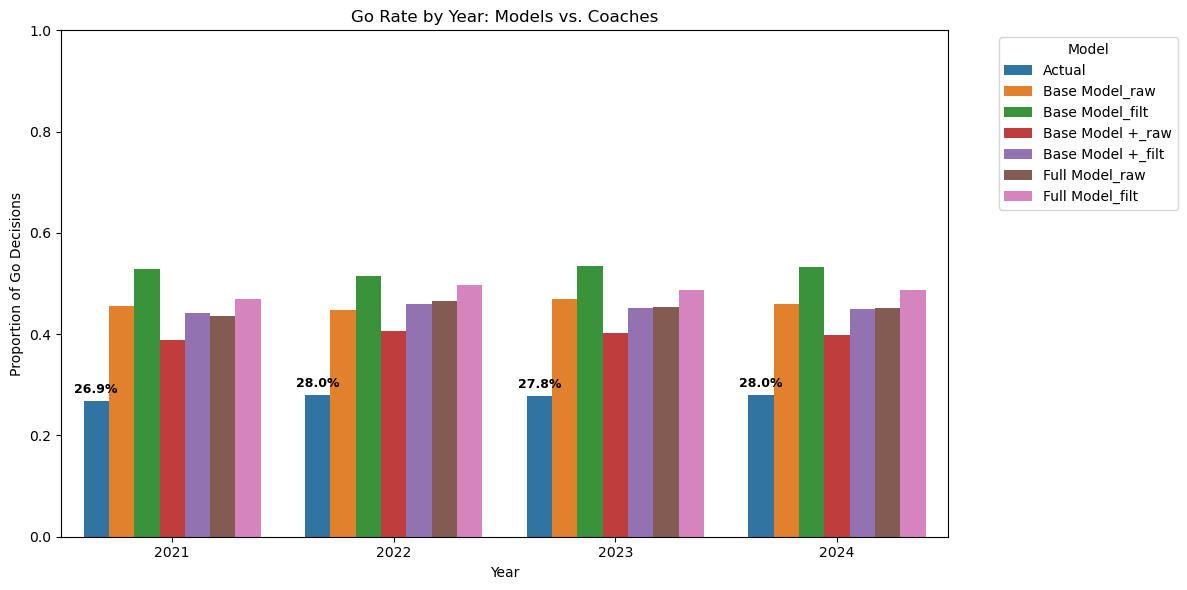

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prep dataset
model_cols = [
    'Base Model_optimal_choice_raw',
    'Base Model_optimal_choice_filt',
    'Base Model +_optimal_choice_raw',
    'Base Model +_optimal_choice_filt',
    'Full Model_optimal_choice_raw',
    'Full Model_optimal_choice_filt'
]

# Step 2: Create long-format dataframe of go rates by year and source
rows = []
for year, group in fourth_downs.groupby('year'):
    # Actual go rate
    actual_go = (group['actual_choice'] == 'go_EWP').mean()
    rows.append({'year': year, 'source': 'Actual', 'pct_go': actual_go})

    # Model go rates
    for col in model_cols:
        pct_go_model = (group[col] == 'go_EWP').mean()
        label = col.replace('_optimal_choice', '')
        rows.append({'year': year, 'source': label, 'pct_go': pct_go_model})

aggression_df = pd.DataFrame(rows)

# Step 3: Plot bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=aggression_df, x='year', y='pct_go', hue='source')

# Step 4: Annotate only 'Actual' bars with percentage labels
actual_data = aggression_df[aggression_df['source'] == 'Actual'].reset_index(drop=True)
n_sources = aggression_df['source'].nunique()
bar_width = 0.8 / n_sources

for i, row in actual_data.iterrows():
    year_index = aggression_df['year'].sort_values().unique().tolist().index(row['year'])
    x = year_index - 0.4 + bar_width / 2  # left edge + half-width of first bar
    y = row['pct_go']
    ax.text(x, y + 0.01, f"{y:.1%}", ha='center', va='bottom', fontsize=9, weight='bold')

# Step 5: Final touches
plt.title('Go Rate by Year: Models vs. Coaches')
plt.ylabel('Proportion of Go Decisions')
plt.xlabel('Year')
plt.ylim(0, 1)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [245]:
import statsmodels.api as sm

# Filter only 'Actual' data
actual_data = aggression_df[aggression_df['source'] == 'Actual'].copy()
actual_data = actual_data.sort_values('year')
actual_data['year_numeric'] = actual_data['year'] - actual_data['year'].min()  # Normalize for stability

X = sm.add_constant(actual_data['year_numeric'])  # Add intercept
y = actual_data['pct_go']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 pct_go   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     2.447
Date:                Mon, 07 Apr 2025   Prob (F-statistic):              0.258
Time:                        20:11:34   Log-Likelihood:                 17.492
No. Observations:                   4   AIC:                            -30.98
Df Residuals:                       2   BIC:                            -32.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2720      0.004     75.322   

C:\Users\12246\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


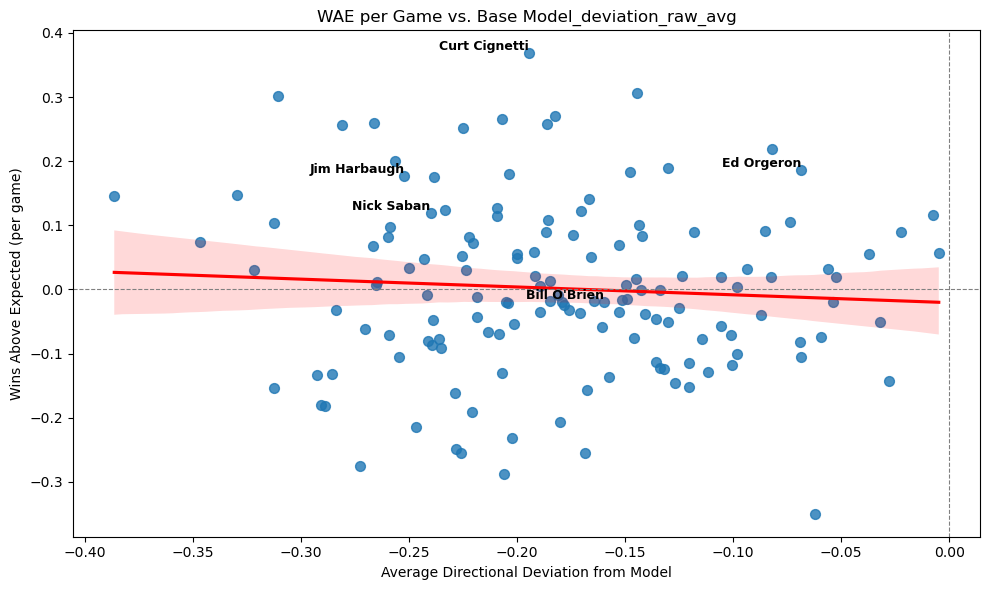

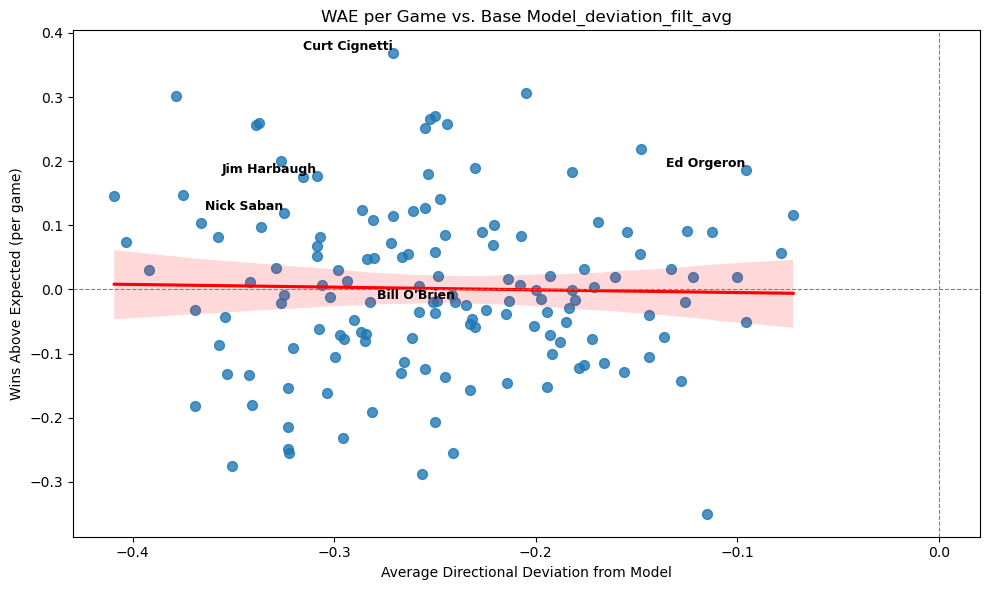

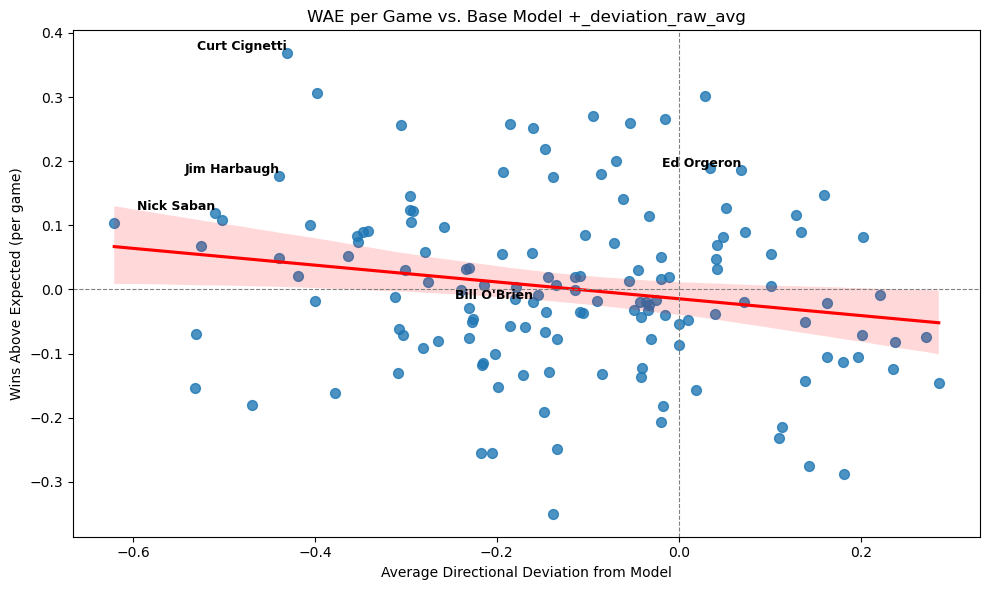

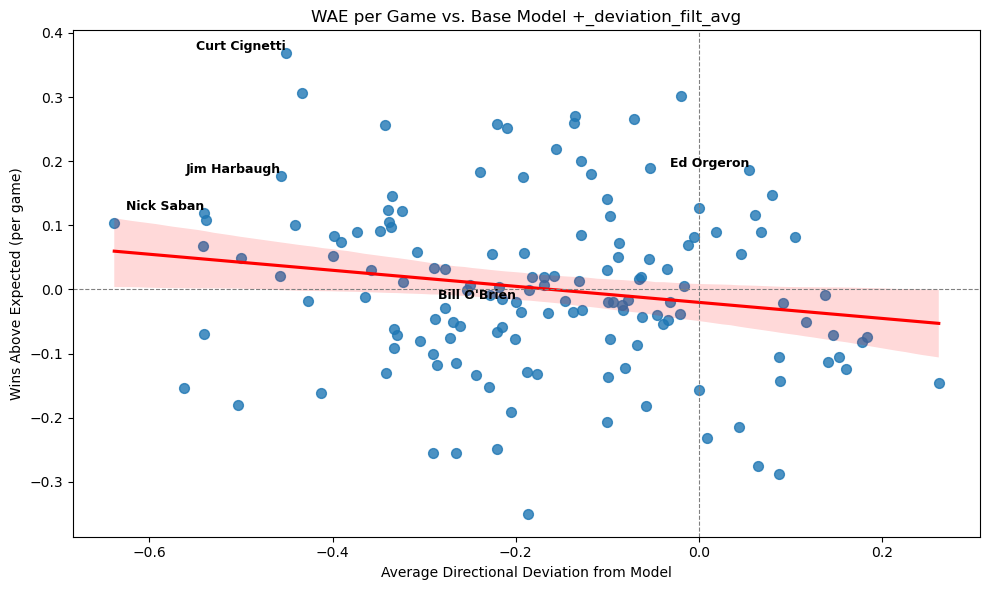

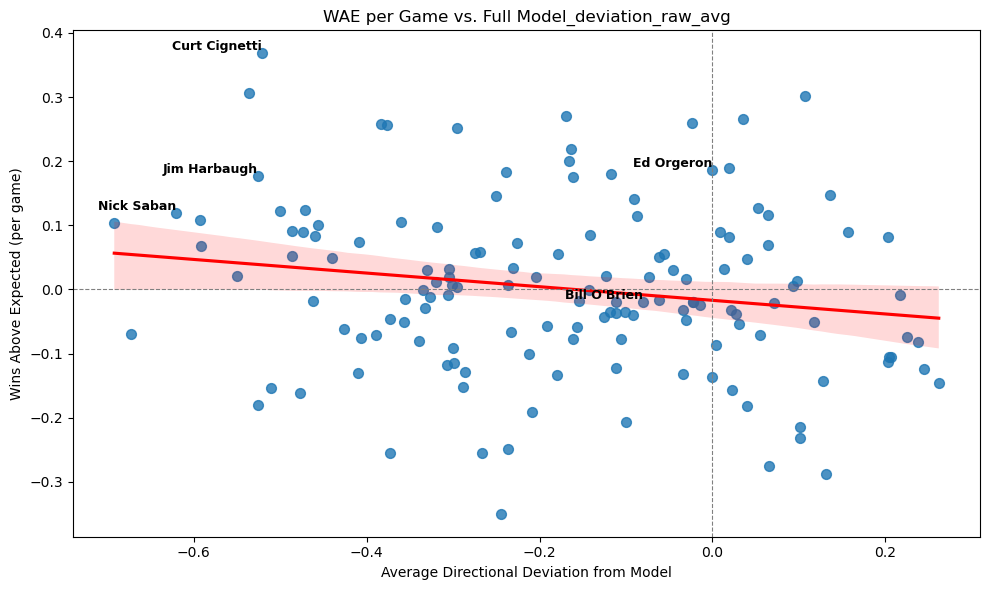

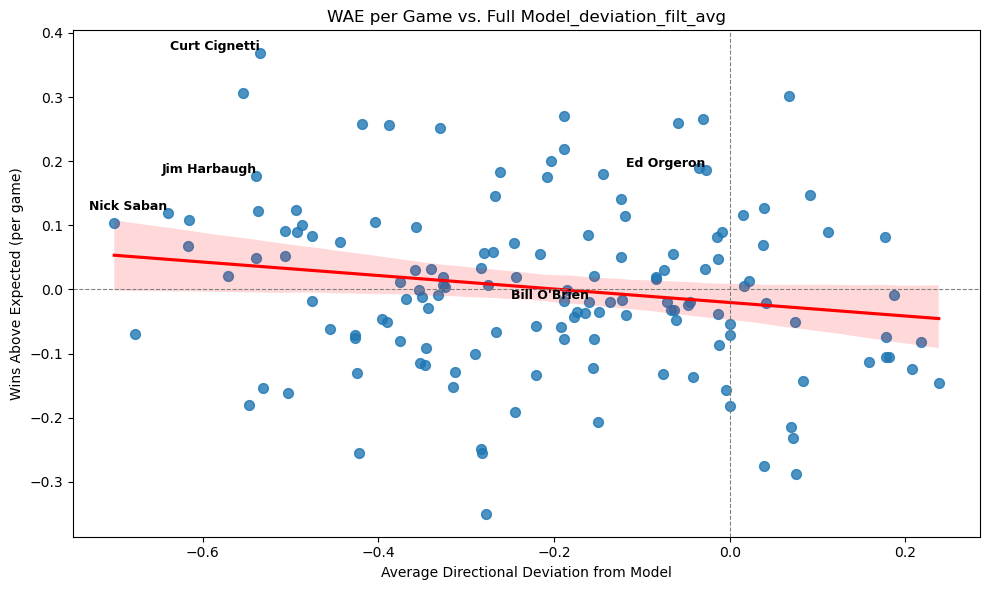

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define model columns
deviation_cols = [
    'Base Model_deviation_raw_avg',
    'Base Model_deviation_filt_avg',
    'Base Model +_deviation_raw_avg',
    'Base Model +_deviation_filt_avg',
    'Full Model_deviation_raw_avg',
    'Full Model_deviation_filt_avg'
]

# Notable coaches to highlight
notable_coaches = ["Nick Saban", "Jim Harbaugh", "Bill O'Brien", "Curt Cignetti", "Ed Orgeron"]

# Loop through models and plot
for col in deviation_cols:
    plt.figure(figsize=(10, 6))
    sns.regplot(data=coach_df, x=col, y='WAE_per_game', scatter_kws={'s': 50}, line_kws={'color': 'red'})

    # Annotate notable coaches
    for _, row in coach_df.iterrows():
        if row['coach'] in notable_coaches:
            plt.text(
                row[col], row['WAE_per_game'],
                row['coach'],
                fontsize=9, fontweight='bold',
                ha='right', va='bottom'
            )

    # Plot details
    plt.title(f"WAE per Game vs. {col}")
    plt.xlabel("Average Directional Deviation from Model")
    plt.ylabel("Wins Above Expected (per game)")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()


C:\Users\12246\anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\12246\anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


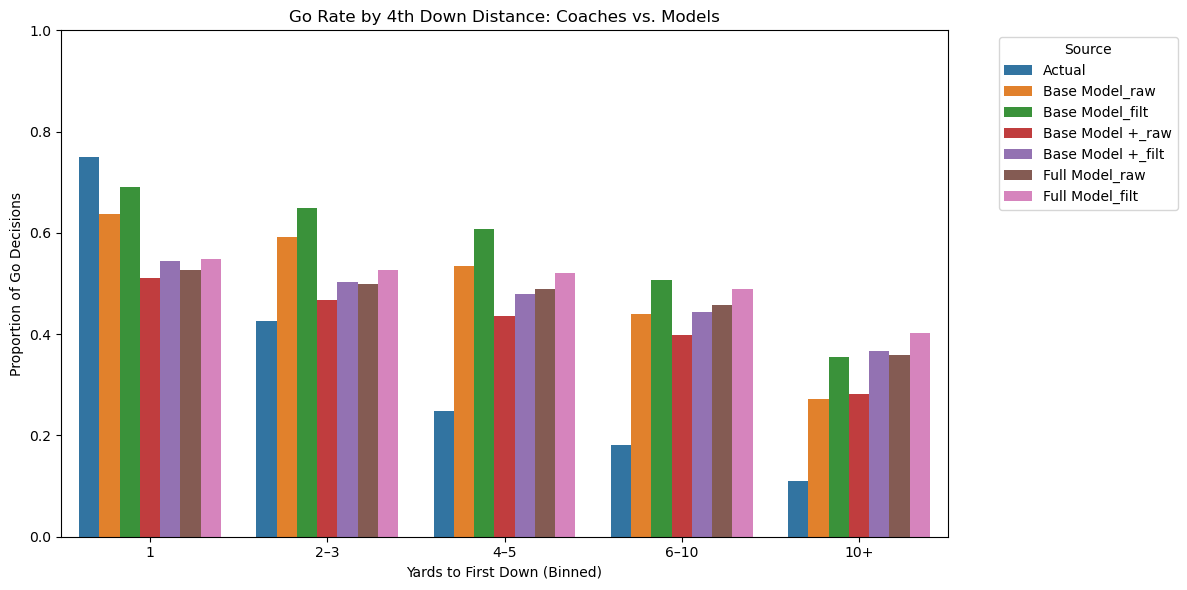

In [229]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Bin 4th down distance
def bin_distance(yards):
    if yards == 1:
        return '1'
    elif 2 <= yards <= 3:
        return '2–3'
    elif 4 <= yards <= 5:
        return '4–5'
    elif 6 <= yards <= 10:
        return '6–10'
    else:
        return '10+'

fourth_downs['distance_bin'] = fourth_downs['start_yfd'].apply(bin_distance)

# Step 2: Calculate go rates per bin
model_cols = [
    'Base Model_optimal_choice_raw',
    'Base Model_optimal_choice_filt',
    'Base Model +_optimal_choice_raw',
    'Base Model +_optimal_choice_filt',
    'Full Model_optimal_choice_raw',
    'Full Model_optimal_choice_filt'
]

rows = []
for dist_bin, group in fourth_downs.groupby('distance_bin'):
    # Actual go rate
    actual_go = (group['actual_choice'] == 'go_EWP').mean()
    rows.append({'distance_bin': dist_bin, 'source': 'Actual', 'pct_go': actual_go})

    # Model go rates
    for col in model_cols:
        pct_model = (group[col] == 'go_EWP').mean()
        label = col.replace('_optimal_choice', '')
        rows.append({'distance_bin': dist_bin, 'source': label, 'pct_go': pct_model})

# Step 3: Create DataFrame
dist_df = pd.DataFrame(rows)

# Optional: Sort bins for logical order
bin_order = ['1', '2–3', '4–5', '6–10', '10+']
dist_df['distance_bin'] = pd.Categorical(dist_df['distance_bin'], categories=bin_order, ordered=True)

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=dist_df, x='distance_bin', y='pct_go', hue='source')
plt.title("Go Rate by 4th Down Distance: Coaches vs. Models")
plt.xlabel("Yards to First Down (Binned)")
plt.ylabel("Proportion of Go Decisions")
plt.ylim(0, 1)
plt.legend(title="Source", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [234]:
#data.head()
summary_stats = [
    'sec_remaining','start_down','start_yfd','yds_to_goal',
    'score_diff','adjScore','off_eff','rz_eff','def_eff',
    'def_rz_eff','to_rate','ex_play','havoc_rate'
    ]
summary = data[summary_stats].copy()
summary.describe()

,sec_remaining,start_down,start_yfd,yds_to_goal,score_diff,adjScore,off_eff,rz_eff,def_eff,def_rz_eff,to_rate,ex_play,havoc_rate
count,299058.000000,299061.000000,299061.000000,299061.000000,299061.000000,299058.000000,298919.000000,298919.000000,298887.000000,298887.000000,298919.000000,298919.000000,298887.000000
mean,1791.917307,1.940353,8.335326,51.551302,-0.673354,-0.033381,0.302384,0.807141,0.702148,0.190291,0.019007,0.063596,0.083114
std,1037.272543,1.041402,4.221484,23.894275,13.867733,0.814945,0.071132,0.111978,0.064812,0.107682,0.008339,0.014887,0.019594
min,0.000000,0.000000,0.000000,1.000000,-73.000000,-53.000000,0.000000,0.000000,0.363636,0.000000,0.000000,0.000000,0.000000
25%,900.000000,1.000000,6.000000,33.000000,-7.000000,-0.212238,0.253521,0.750000,0.661017,0.125000,0.013285,0.053834,0.070423
50%,1819.000000,2.000000,10.000000,56.000000,0.000000,0.000000,0.302158,0.818182,0.702128,0.181818,0.018545,0.062674,0.082143
75%,2678.000000,3.000000,10.000000,71.000000,7.000000,0.162569,0.349206,0.882353,0.743902,0.250000,0.023810,0.073218,0.094136
max,3600.000000,4.000000,95.000000,100.000000,73.000000,34.000000,0.666667,1.000000,1.000000,1.000000,0.080292,0.333333,0.214286


In [236]:
import numpy as np
import pandas as pd

# Make a copy to avoid altering original data
data_wp = data.copy()

# Define model features (same as before)
feature_sets = {
    "Base Model": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd'],
    "Base Model +": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd', 'adjScore', 'spread'],
    "Full Model": ['sec_remaining', 'score_diff', 'yds_to_goal', 'has_possession', 'start_down', 'start_yfd', 'adjScore', 'spread', 'off_eff', 'rz_eff', 'to_rate', 'ex_play', 'def_eff', 'def_rz_eff', 'havoc_rate']
}

# Predict WP for every row in `data` for each model
for model_name, model in models.items():
    features = feature_sets[model_name]
    data_wp[f'{model_name}_wp'] = model.predict_proba(data_wp[features])[:, 1]


In [238]:
# Function to bin predictions and compute observed win rate
def calibrate_wp(df, wp_col, outcome_col='outcome'):
    df = df.copy()
    df['wp_bin'] = pd.cut(df[wp_col], bins=np.arange(0, 1.05, 0.05), include_lowest=True)
    bin_means = df.groupby('wp_bin')[outcome_col].mean().reset_index()
    bin_means.columns = ['WP_Bin', 'Observed_Win_Rate']
    bin_means['Bin_Center'] = bin_means['WP_Bin'].apply(lambda x: (x.left + x.right) / 2)
    bin_means['Model'] = wp_col
    return bin_means

# Compile calibration results across models
calibration_results = pd.concat(
    [calibrate_wp(data_wp, f'{model_name}_wp') for model_name in models.keys()],
    ignore_index=True
)

C:\Users\12246\AppData\Local\Temp\ipykernel_51548\191586512.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('wp_bin')[outcome_col].mean().reset_index()
C:\Users\12246\AppData\Local\Temp\ipykernel_51548\191586512.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('wp_bin')[outcome_col].mean().reset_index()
C:\Users\12246\AppData\Local\Temp\ipykernel_51548\191586512.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

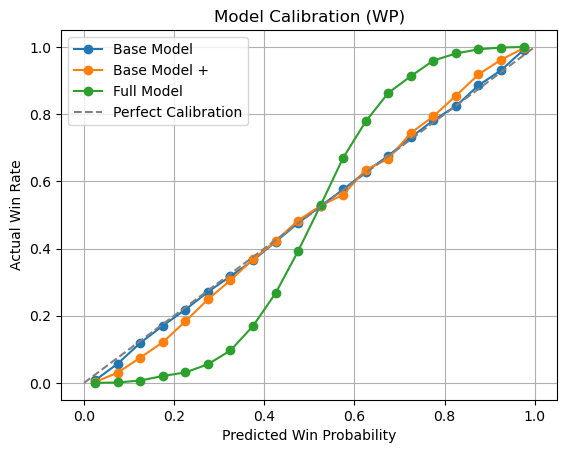

In [239]:
import matplotlib.pyplot as plt

for model_name in models.keys():
    model_data = calibration_results[calibration_results['Model'] == f'{model_name}_wp']
    plt.plot(model_data['Bin_Center'], model_data['Observed_Win_Rate'], marker='o', label=model_name)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Predicted Win Probability")
plt.ylabel("Actual Win Rate")
plt.title("Model Calibration")
plt.legend()
plt.grid(True)
plt.show()


In [241]:
# Compute correlation (Pearson's r) between predicted WP (bin center) and actual win rate per model
correlations = (
    calibration_results
    .groupby('Model')
    .apply(lambda g: g['Bin_Center'].corr(g['Observed_Win_Rate']))
    .reset_index()
)
correlations.columns = ['Model', 'Calibration_Correlation']

print(correlations)

             Model  Calibration_Correlation
0  Base Model +_wp                 0.999263
1    Base Model_wp                 0.999921
2    Full Model_wp                 0.967821


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\2937524799.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_results


In [246]:
keep = ['actual_wins','expected_wins','WAE','games_coached','WAE_per_game',
        'Base Model_deviation_raw_avg','Base Model_deviation_filt_avg',
        'Base Model +_deviation_raw_avg','Base Model +_deviation_filt_avg',
        'Full Model_deviation_raw_avg','Full Model_deviation_filt_avg']

#coach_df[keep].describe()
coach_df.describe()

,actual_wins,expected_wins,WAE,games_coached,Base Model_deviation_raw_sum,Base Model_deviation_raw_count,Base Model_deviation_raw_avg,Base Model_deviation_filt_sum,Base Model_deviation_filt_count,Base Model_deviation_filt_avg,Base Model +_deviation_raw_sum,Base Model +_deviation_raw_count,Base Model +_deviation_raw_avg,Base Model +_deviation_filt_sum,Base Model +_deviation_filt_count,Base Model +_deviation_filt_avg,Full Model_deviation_raw_sum,Full Model_deviation_raw_count,Full Model_deviation_raw_avg,Full Model_deviation_filt_sum,Full Model_deviation_filt_count,Full Model_deviation_filt_avg,WAE_per_game
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,6.244755,6.198312,0.046444,12.321678,-34.034965,187.748252,-0.179979,-46.727273,187.748252,-0.248394,-25.447552,187.748252,-0.121504,-34.923077,187.748252,-0.172371,-35.832168,187.748252,-0.172804,-42.062937,187.748252,-0.206928,0.001480
std,4.097778,3.600697,1.517647,4.740597,18.853181,62.307107,0.075436,21.558366,62.307107,0.074725,37.859205,62.307107,0.192833,37.257966,62.307107,0.182790,45.612728,62.307107,0.223554,45.383998,62.307107,0.218481,0.132254
min,0.000000,0.877278,-3.980550,2.000000,-111.000000,25.000000,-0.386364,-129.000000,25.000000,-0.409091,-139.000000,25.000000,-0.620536,-143.000000,25.000000,-0.638393,-155.000000,25.000000,-0.691964,-161.000000,25.000000,-0.700893,-0.349598
25%,3.000000,3.292491,-0.935440,8.000000,-45.500000,144.000000,-0.234387,-60.000000,144.000000,-0.304803,-50.500000,144.000000,-0.236805,-56.000000,144.000000,-0.290239,-71.000000,144.000000,-0.330909,-76.500000,144.000000,-0.357957,-0.077524
50%,6.000000,6.084190,-0.128593,13.000000,-32.000000,199.000000,-0.184549,-45.000000,199.000000,-0.251121,-18.000000,199.000000,-0.133858,-25.000000,199.000000,-0.176471,-26.000000,199.000000,-0.161538,-35.000000,199.000000,-0.189189,-0.008584
75%,8.500000,8.183126,0.941611,16.000000,-21.000000,238.000000,-0.131172,-31.500000,238.000000,-0.193747,0.000000,238.000000,0.000000,-8.000000,238.000000,-0.053847,1.000000,238.000000,0.006646,-5.000000,238.000000,-0.032393,0.084155
max,21.000000,18.607275,4.597858,24.000000,-1.000000,320.000000,-0.004902,-6.000000,320.000000,-0.072243,53.000000,320.000000,0.285714,33.000000,320.000000,0.261905,52.000000,320.000000,0.261905,45.000000,320.000000,0.238095,0.368208


In [247]:
data_wp.head()

,play_id,year,week,neutral_site,attendance,quarter,score_points,start_yard_line,start_down,start_yfd,end_yard_line,end_down,end_yfd,pass_att,pass_cmp,pass_yds,pass_sk,pass_sk_yds,pass_td,pass_int,pass_fd,pass_rz_att,pass_sfty,rec_tar,rec_rec,rec_yds,rec_td,rec_fd,rec_rz_tar,rec_sfty,rush_att,rush_yds,rush_td,rush_fd,rush_rz_att,rush_sfty,rush_tlost,rush_tlost_yards,fg_att,fg_made,fg_miss,fg_yds,fg_blk,xp_att,xp_made,xp_missed,two_pt_att,two_pt_cmp,misc_yards,pen_yds,pen_count,def_tlost,def_ast_tlost,def_tlost_yds,def_sack,def_ast_sack,def_sack_yds,def_sfty,def_int,def_int_yds,def_int_td,def_force_fum,def_qb_hit,def_pass_defended,def_block,kickoffs_kicks,kickoffs_yds,kickoffs_gross_yds,kickoffs_net_yds,kickoffs_endzone,kickoffs_in20,kickoffs_tb,kick_ret_returns,kick_ret_yds,kick_ret_fc,kick_ret_td,kick_ret_type,kick_ret_tb,kick_ret_oob,punt_punts,punt_yds,punt_net_yds,punt_blk,punt_in20,punt_tb,fumb_fum,fumb_forced,fumb_lost,fumb_oob,fum_ret_own_rec,fum_ret_opp_rec,fum_ret_opp_rec_yds,fum_ret_own_rec_yds,fum_ret_opp_rec_td,fum_ret_own_rec_td,block_block,sec_remaining,outcome,yds_to_goal,scheduled_date,home_abbr,home_market,home_name,away_abbr,away_market,away_name,position,start_clock,summary,start_team,start_side,end_team,end_side,penalty_responsible,home_pts,away_pts,score_diff,spread,match,hcgamescoached,hcgameswon,hcfirstname,hclastname,v16,acgamescoached,acgameswon,acfirstname,aclastname,has_possession,adjScore,drive_id,off_eff,rz_eff,to_rate,ex_play,def_eff,def_rz_eff,havoc_rate,points_scored,points_scored_drive,goal_to_go,play_type_conversion,play_type_extra_point,play_type_field_goal,play_type_kickoff,play_type_pass,play_type_penalty,play_type_punt,play_type_rush,play_type_scrimmage,team_market,home_win_prob,Base Model_optimal_choice_raw,Base Model_optimal_choice_filt,Base Model +_optimal_choice_raw,Base Model +_optimal_choice_filt,Full Model_optimal_choice_raw,Full Model_optimal_choice_filt,actual_choice,home_coach,away_coach,home_win,away_win,home_ex_wins,away_ex_wins,gc,Base Model_deviation_raw,Base Model_deviation_filt,Base Model +_deviation_raw,Base Model +_deviation_filt,Full Model_deviation_raw,Full Model_deviation_filt,Base Model_wp,Base Model +_wp,Full Model_wp
0,115690,2021,7,NaN,34446,1,NaN,35,1,10,31,2,10,1,1,6,0,0,0,0,0,0,0,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3600.0,0,75,10/17/2021,BOISE,Boise State,Broncos,AF,Air Force,Falcons,WR,15:00,H.Bachmeier pass complete to BOISE 25. Catch m...,BOISE,BOISE,BOISE,BOISE,NaN,0,0,0,-3.0,2021_Air Force@Boise State_7,12,7,Andy,Avalos,NaN,13,10,Troy,Calhoun,1,0.0,175.0,0.340909,0.84,0.022039,0.074380,0.764706,0.2,0.081081,0.0,7,0,False,False,False,False,True,False,False,False,1,NaN,0.567662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andy Avalos,Troy Calhoun,0.0,1.0,0.567662,0.432338,1.0,0,0,0,0,0,0,0.566269,0.492426,0.759948
1,115688,2021,7,NaN,34446,1,NaN,31,2,4,39,1,10,1,1,8,0,0,0,0,1,0,0,1,1,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3583.0,0,69,10/17/2021,BOISE,Boise State,Broncos,AF,Air Force,Falcons,WR,14:43,H.Bachmeier pass complete to BOISE 31. Catch m...,BOISE,BOISE,BOISE,BOISE,NaN,0,0,0,-3.0,2021_Air Force@Boise State_7,12,7,Andy,Avalos,NaN,13,10,Troy,Calhoun,1,0.0,175.0,0.340909,0.84,0.021978,0.074176,0.764706,0.2,0.080838,0.0,7,0,False,False,False,False,True,False,False,False,1,NaN,0.567662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andy Avalos,Troy Calhoun,0.0,0.0,0.000000,0.000000,0.0,0,0,0,0,0,0,0.586856,0.524090,0.621497
2,115684,2021,7,NaN,34446,1,NaN,39,1,10,43,2,6,1,1,4,0,0,0,0,0,0,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3553.0,0,61,10/17/2021,BOISE,Boise State,Broncos,AF,Air Force,Falcons,RB,14:13,H.Bachmeier pass complete to BOISE 39. Catch m...,BOISE,BOISE,BOISE,BOISE

C:\Users\12246\AppData\Local\Temp\ipykernel_51548\4252819687.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df_final.groupby("diff_bin")[["full_correct", "base_correct"]].mean().reset_index()


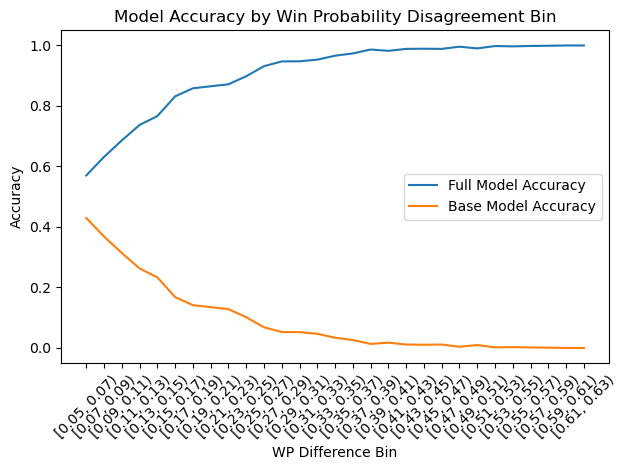

In [261]:
import pandas as pd
import numpy as np

df = data_wp.copy()

# Step 1: Calculate the difference between full and base models
df["wp_diff"] = df["Full Model_wp"] - df["Base Model +_wp"]
df["abs_diff"] = df["wp_diff"].abs()

limit = 0.05
# Step 2: Filter for meaningful disagreements
df_filtered = df[df["abs_diff"] >= limit].copy()

# Step 3: Create bins for abs_diff
bins = np.arange(limit, 0.65, 0.02)
df_filtered["diff_bin"] = pd.cut(df_filtered["abs_diff"], bins=bins, right=False)

# Step 4: Determine predicted winner by each model
df_filtered["full_pred"] = (df_filtered["Full Model_wp"] >= 0.5).astype(int)
df_filtered["base_pred"] = (df_filtered["Base Model +_wp"] >= 0.5).astype(int)

# Step 5: Check prediction accuracy
df_filtered["full_correct"] = (df_filtered["full_pred"] == df_filtered["outcome"]).astype(int)
df_filtered["base_correct"] = (df_filtered["base_pred"] == df_filtered["outcome"]).astype(int)

df_final = df_filtered[df_filtered["full_pred"] != df_filtered["base_pred"]]

# Step 6: Aggregate accuracy by bin
results = df_final.groupby("diff_bin")[["full_correct", "base_correct"]].mean().reset_index()

import matplotlib.pyplot as plt

# Optional: Plotting the accuracy
plt.plot(results["diff_bin"].astype(str), results["full_correct"], label="Full Model Accuracy")
plt.plot(results["diff_bin"].astype(str), results["base_correct"], label="Base Model Accuracy")
plt.xlabel("WP Difference Bin")
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Win Probability Disagreement Bin")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\12246\AppData\Local\Temp\ipykernel_51548\2972946002.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_plus = df_plus_final.groupby("diff_bin")[["full_correct", "plus_correct"]].mean().reset_index()
C:\Users\12246\AppData\Local\Temp\ipykernel_51548\2972946002.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_base = df_base_final.groupby("diff_bin")[["full_correct", "base_correct"]].mean().reset_index()


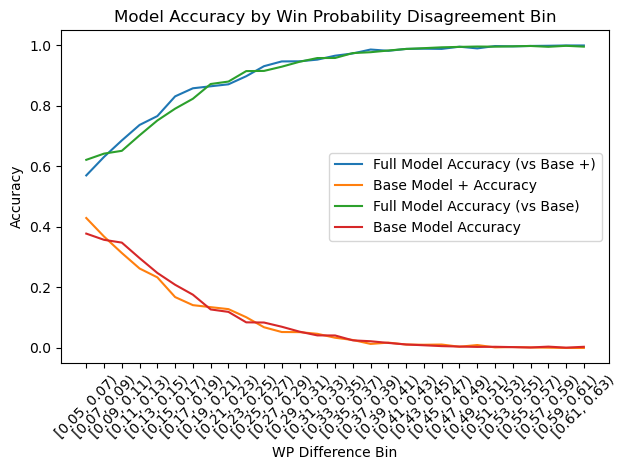

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = data_wp.copy()

# --- Step 1: Calculate differences ---
df["wp_diff_plus"] = df["Full Model_wp"] - df["Base Model +_wp"]
df["abs_diff_plus"] = df["wp_diff_plus"].abs()

df["wp_diff_base"] = df["Full Model_wp"] - df["Base Model_wp"]
df["abs_diff_base"] = df["wp_diff_base"].abs()

limit = 0.05
bins = np.arange(limit, 0.65, 0.02)

# --- Step 2: Analyze disagreement for Base Model + ---
df_plus = df[df["abs_diff_plus"] >= limit].copy()
df_plus["diff_bin"] = pd.cut(df_plus["abs_diff_plus"], bins=bins, right=False)
df_plus["full_pred"] = (df_plus["Full Model_wp"] >= 0.5).astype(int)
df_plus["plus_pred"] = (df_plus["Base Model +_wp"] >= 0.5).astype(int)
df_plus["full_correct"] = (df_plus["full_pred"] == df_plus["outcome"]).astype(int)
df_plus["plus_correct"] = (df_plus["plus_pred"] == df_plus["outcome"]).astype(int)
df_plus_final = df_plus[df_plus["full_pred"] != df_plus["plus_pred"]]
results_plus = df_plus_final.groupby("diff_bin")[["full_correct", "plus_correct"]].mean().reset_index()

# --- Step 3: Analyze disagreement for Base Model (original) ---
df_base = df[df["abs_diff_base"] >= limit].copy()
df_base["diff_bin"] = pd.cut(df_base["abs_diff_base"], bins=bins, right=False)
df_base["full_pred"] = (df_base["Full Model_wp"] >= 0.5).astype(int)
df_base["base_pred"] = (df_base["Base Model_wp"] >= 0.5).astype(int)
df_base["full_correct"] = (df_base["full_pred"] == df_base["outcome"]).astype(int)
df_base["base_correct"] = (df_base["base_pred"] == df_base["outcome"]).astype(int)
df_base_final = df_base[df_base["full_pred"] != df_base["base_pred"]]
results_base = df_base_final.groupby("diff_bin")[["full_correct", "base_correct"]].mean().reset_index()

# --- Step 4: Plotting ---
plt.plot(results_plus["diff_bin"].astype(str), results_plus["full_correct"], label="Full Model Accuracy (vs Base +)")
plt.plot(results_plus["diff_bin"].astype(str), results_plus["plus_correct"], label="Base Model + Accuracy")

plt.plot(results_base["diff_bin"].astype(str), results_base["full_correct"], label="Full Model Accuracy (vs Base)")
plt.plot(results_base["diff_bin"].astype(str), results_base["base_correct"], label="Base Model Accuracy")

plt.xlabel("WP Difference Bin")
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Win Probability Disagreement Bin")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
